# Building a `ws3` model from scratch

This notebook has an example of building a new `ws3` model from scratch.

> We _strongly recommend_ that you run this notebook in venv-sandboxed Python kernel (see `venv_python_kernel_setup` notebook for an example of how to do this). This will ensure that you are working from a fresh Python package environment, and not wasting time debugging random interactions between this notebook and whatever mishmash of packages you have installed on your system in various parts of your Python path. You have been warned. 

## Install required packages

In [1]:
%pip install pandas geopandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -U git+https://github.com/gparadis/ws3@dev

  Cloning https://github.com/gparadis/ws3 (to revision dev) to /media/data/tmp/pip-req-build-190ifp72
  Running command git clone --filter=blob:none --quiet https://github.com/gparadis/ws3 /media/data/tmp/pip-req-build-190ifp72
  Resolved https://github.com/gparadis/ws3 to commit 3f5745d34bc4c2c86897bdad128deac8c6d8f87c
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for ws3, since package 'wheel' is not installed.
  Attempting uninstall: ws3
    Found existing installation: ws3 0.0.1.post3
    Uninstalling ws3-0.0.1.post3:
      Successfully uninstalled ws3-0.0.1.post3
  Running setup.py install for ws3 ... done
Note: you may need to restart the kernel to use updated packages.


Uncomment the commands below _only_ if you want to uninstall the ws3 package and replace it with a pointer to _this local clone of the GitHub repository code_ (useful if you want ot tweak the source code for whatever reason). 

In [3]:
%pip uninstall -y ws3
%pip install -e ..

Found existing installation: ws3 0.0.1.post3
Uninstalling ws3-0.0.1.post3:
  Successfully uninstalled ws3-0.0.1.post3
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///media/data/project/gparadis/ws3
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ws3
Note: you may need to restart the kernel to use updated packages.


## Import required packages

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core

## Set up Python environment

Define some basic parameters.

In [6]:
base_year = 2020
horizon = 10
period_length = 10
max_age = 1000
tvy_name = 'totvol'

Import sample inventory and yield curve data.

The inventory data is imported a from vector data layer (stored in industry-standard ESRI Shapefile format). This is a small square of real forest data clipped from a larger dataset representing Timber Supply Area (TSA) 24 in British Columbia (BC), Canada. This data layer is derived from publicly-available BC Vegetation Resource Inventory (VRI) datasets (see [British Columbia Data Catalogue](https://catalogue.data.gov.bc.ca/)) that we pre-processed to include the data attributes we need (in the format we want) for this `ws3` model-building example. 

The yield curve data was generated from a complex process (the details of which are outside the scope of this example, contact [Gregory Paradis](mailto:gregory.paradis@ubc.ca) for details), using a methodology consistent with _de facto_ professional best-practices for the Timber Supply Review (TSR) modelling process in BC. 

In [7]:
stands = gpd.read_file('data/shp/tsa24_clipped.shp/stands.shp')

In [8]:
stands

,theme0,theme1,theme2,curve1,curve2,SPECIES_CD,age,area,theme3,geometry
0,tsa24_clipped,1,2401002,2401002,2401002,PLI,145,0.111814,204,"MULTIPOLYGON (((1112711.004 1120816.405, 11127..."
1,tsa24_clipped,1,2401002,2401002,2401002,PLI,145,0.113925,204,"POLYGON ((1113299.500 1120834.770, 1113298.336..."
2,tsa24_clipped,1,2401002,2401002,2401002,PLI,135,7.025088,204,"POLYGON ((1112035.066 1121064.403, 1112071.399..."
3,tsa24_clipped,1,2402002,2402002,2402002,PLI,93,11.029940,204,"POLYGON ((1114394.740 1120822.943, 1114394.421..."
4,tsa24_clipped,1,2401000,2401000,2401000,SX,145,9.581284,100,"MULTIPOLYGON (((1114322.804 1120983.973, 11143..."
...,...,...,...,...,...,...,...,...,...,...
185,tsa24_clipped,1,2401002,2401002,2401002,PLI,85,5.667730,204,"POLYGON ((1115036.356 1124809.762, 1115037.888..."
186,tsa24_clipped,1,2401002,2401002,2401002,PLI,85,1.811041,204,"POLYGON ((1114157.650 1124633.924, 1114154.478..."
187,tsa24_clipped,1,2401002,2401002,2401002,PLI,95,1.137586,204,"POLYGON ((1114675.233 1124802.103, 1114684.360..."
188,tsa24_clipped,0,2401000,2401000,2401000,SB,95,0.494253,100,"POLYGON ((1114249.328 1124669.031, 1114271.225..."


Import data tables linking analysis units to yield curves.

In [9]:
au_table = pd.read_csv('data/au_table.csv').set_index('au_id')
curve_table = pd.read_csv('data/curve_table.csv')
curve_points_table = pd.read_csv('data/curve_points_table.csv').set_index('curve_id')

In [10]:
au_table['thlb'] = au_table.apply(lambda row: 0 if row.unmanaged_curve_id == row.managed_curve_id else 1, axis=1)

In [11]:
au_table

,record_id,tsa,stratum_code,si_level,canfi_species,unmanaged_curve_id,managed_curve_id,thlb
au_id,,,,,,,,
2401000,63,24,SBS_SX,L,100,2401000,2401000,0
2402000,64,24,SBS_SX,M,100,2402000,2422000,1
2403000,65,24,SBS_SX,H,100,2403000,2423000,1
2401001,66,24,ESSF_BL,L,304,2401001,2401001,0
2402001,67,24,ESSF_BL,M,304,2402001,2402001,0
2403001,68,24,ESSF_BL,H,304,2403001,2423001,1
2401002,69,24,SBS_PLI,L,204,2401002,2421002,1
2402002,70,24,SBS_PLI,M,204,2402002,2422002,1
2403002,71,24,SBS_PLI,H,204,2403002,2423002,1


Need to rebuild the Timber Harvesting Land Base (THLB) attribute (i.e., `theme1`) in the stand inventory table. Current implementation is inconsistent with yield VDYP/TIPSY yield curve (and AU definition) modelling assumptions. 

In a nutshell, AUs either have only a VDYP yield curve or both VDYP and TISPY yield curves (if considered potentially operable). We need to set the THLB attribute to 0 for stands in AUs with have only a VDYP curve (i.e., where `au_table.unmanaged_curve_id == au_table.managed_curve_id`), and 1 otherwise. 

Otherwise, we would get weird cases where we can harvest a stand but there is not TIPSY curve defined for second-growth stand conditions.

In [12]:
stands.theme1 = stands.apply(lambda row: au_table.loc[row.theme2].thlb, axis=1)

Copy `curve1` to `theme4` so we can track yield curve transitions independently from AU.

In [13]:
stands['theme4'] = stands.curve1

Set up themes.

In [14]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AU
            'theme3', # leading species code
            'theme4'] # yield curve ID
basecodes = [list(map(lambda x: str(x), stands[tc].unique())) for tc in theme_cols]

In [15]:
# also scrape au_table for AU and curve ID values that are not in inventory but might pop up later (hack?)
basecodes[2] = list(set(basecodes[2] + list(au_table.index.astype(str))))
basecodes[3] = list(set(basecodes[3] + list(au_table.canfi_species.astype(str))))
basecodes[4] = list(set(basecodes[4] + list(au_table.unmanaged_curve_id.astype(str)) + list(au_table.managed_curve_id.astype(str))))               

In [16]:
basecodes

[['tsa24_clipped'],
 ['1', '0'],
 ['2402002',
  '2403000',
  '2402005',
  '2401006',
  '2401000',
  '2402006',
  '2401007',
  '2403002',
  '2402003',
  '2402004',
  '2401002',
  '2401003',
  '2403004',
  '2402007',
  '2403007',
  '2403006',
  '2402001',
  '2403005',
  '2402000',
  '2401005',
  '2401001',
  '2403001',
  '2401004',
  '2403003'],
 ['304', '204', '104', '1201', '100'],
 ['2402002',
  '2403000',
  '2423000',
  '2423001',
  '2402005',
  '2401006',
  '2401000',
  '2423004',
  '2422000',
  '2421002',
  '2402006',
  '2403002',
  '2401007',
  '2402003',
  '2402004',
  '2422007',
  '2401002',
  '2423003',
  '2401003',
  '2403004',
  '2402007',
  '2403007',
  '2423007',
  '2403006',
  '2423002',
  '2421007',
  '2422004',
  '2402001',
  '2403005',
  '2402000',
  '2422002',
  '2401005',
  '2401001',
  '2403001',
  '2401004',
  '2422003',
  '2403003']]

Create a new blank `ForestModel` instance.

In [17]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

Now populate `fm` with data.

Set up themes.

In [18]:
for ti, t in enumerate(theme_cols):
    fm.add_theme(t, basecodes[ti])
fm.nthemes = len(theme_cols)

Load areas from inventory data.

In [19]:
gstands = stands.groupby(theme_cols+['age'])

In [20]:
for name, group in gstands:
    dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
    if dtk not in fm.dtypes:
        fm.dtypes[dtk] = ws3.forest.DevelopmentType(dtk, fm)
    fm.dtypes[dtk].area(0, age, area)

Inspect `dtypes` attribute of `ForestModel` instance.

Directly inject yield curve data into the `fm` instance. 

This a bit obscure, and the exact process will differ from case to case depending on input data structure and desired model structure. This is _not_ the one and only way to do this.

In [21]:
for au_id, au_row in au_table.iterrows():
    yname = 's%04d' % int(au_row.canfi_species)
    for is_managed in (0, 1):
        curve_id = au_row.unmanaged_curve_id if not is_managed else au_row.managed_curve_id
        mask = ('?', '?', str(au_id), '?', str(curve_id))
        points = [(r.x, r.y) for _, r in curve_points_table.loc[curve_id].iterrows() if not r.x % period_length and r.x <= max_age]
        c = fm.register_curve(ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=fm.max_age, period_length=period_length))
        fm.yields.append((mask, 'a', [(yname, c)])) # only if not already present?
        fm.ynames.add(yname) 
        for dtk in fm.unmask(mask): 
            fm.dtypes[dtk].add_ycomp('a', yname, c)

Add total volume curves.

In [22]:
expr = '_SUM(%s)' % ', '.join(fm.ynames)
fm.yields.append((('?', '?', '?', '?', '?'), 'c', [(tvy_name, expr)]))
fm.ynames.add(tvy_name)
for dtk in fm.dtypes.keys(): fm.dtypes[dtk].add_ycomp('c', tvy_name, expr)  

Set up actions. This part is a bit ugly, because `ws3` was originally designed to import Woodstock code (not to directly code models like this). As with yield curves, there is more than one way to implement this, and the details will depend on your input data format and exactly what model you are trying to build.

All of this gets automatically set up correctly if you use the built-in functions to import Woostock-style input files, but is your responsibility if you bypass and direct-code your model.

There is a lot going on here. 

Generic transitions are configured at the `ForestModel` level. These are basically equivalent (conceptually, and functionally) to transitions defined in a Woodstock model. The source masks allow `ws3` to match the key of a new development type (whose runtime instantiation is triggered by application of an action) to one or more appropriate transitions, which then get compiled into the new development type. Etc. Makes more sense if you understand how Woodstock models work. Need to provide more information about this in the `ws3` documentation.

In [23]:
acode = 'harvest'
oe = '_age >= 40 and _age <= 500' # operability expression
oe = 'totvol >= 50 and _age <= 500' # operability expression
fm.transitions[acode] = {}
for au_id, au_row in au_table.iterrows():
    if not au_row.thlb: continue
    target_curve_id = au_row.managed_curve_id
    smask = ('?', '?', str(au_id), '?', '?')
    tmask = ('?', '?', '?', '?', str(target_curve_id))
    target = [(tmask, 1.0, None, None, None, None, None)] # list of one (single target... not modelling "divergent" transitions)
    fm.actions[acode] = ws3.forest.Action(acode, targetage=0, is_harvest=True)
    fm.oper_expr[acode] = {smask:oe}        
    fm.transitions[acode].update({smask:{'':target}}) # the '' is a blank source condition expression
    for dtk in fm.unmask(smask):
        dt = fm.dtypes[dtk]
        dt.oper_expr[acode] = [oe]
        for age in range(1, fm.max_age):
            if not dt.is_operable(acode, 1, age): continue
            #if dtk == ('tsa24_clipped', '1', '2402000', '100', '2402000'):
            #    print('setting transition for', dtk, age, 'to', target)
            fm.dtypes[dtk].transitions[acode, age] = target

In [24]:
fm.compile_actions()

## Poke around `ForestModel` instance data structures to see what we just did

We can poke around the model data structures a bit to see the data we injected above.

Print list of yield component names we are using in this model. In our case, the `sXXX` curves are species-specific yield curves where `XXX` is a [CANFI](https://nfi.nfis.org/en/history) tree species code.

In [25]:
fm.ynames

{'s0100', 's0104', 's0204', 's0304', 's1201', 'totvol'}

List yield components present in our example `DevelopmentType` instance from earlier.

In [26]:
dt.ycomps()

['s0204', 'totvol']

Get a reference to the total yield curve.

The `ws3.core.Curve` class can do all sorts of neat things with yield curve (e.g., curves can resample themselves, interpolate between data points, extrapolate beyond data points, be operated on using standard Python arithmetic operators, CAI, MAI, YTP, etc.). See source code for details. 

In [27]:
c = dt.ycomp('totvol')

In [28]:
c.points()

[(0, 0.0),
 (30, 0.2),
 (40, 24.4),
 (50, 98.20000000000002),
 (60, 184.10000000000002),
 (70, 257.4),
 (80, 312.6),
 (90, 353.8),
 (100, 380.3),
 (110, 400.5),
 (120, 413.0),
 (130, 422.1),
 (140, 428.7),
 (150, 433.3),
 (160, 435.0),
 (180, 437.4),
 (190, 436.8),
 (200, 434.7),
 (210, 433.0),
 (230, 430.5),
 (250, 428.9),
 (1000, 426.9)]

Plot total volume, CAI, MAI, MAI YTP, etc. Optimal rotation age in red.

Note that all the stuff a forester would expect to see happening with these yield curves is seems to be happening:
* A tangent to the volume curve passing through the origin touches the yield curve at the optimal rotation age.
* The CAI curve is blocky because curve points are sparse (curves have been automatically resampled to 10-year intervals by default, so the yield curve is actually a piecewise linear assemblage).
* The MAI curve intersects the CAI curve at the optimal rotation age.

This is not meant to be an exhaustive demonstration of `ws3` curve manipulation and usage. Go have a look at the source code to see what else you can do. The `Curve` class implementation is intended to help avoid needing to so low-level math and logic on curve datasets for most typical model-building use cases.

(0.0, 300.0)

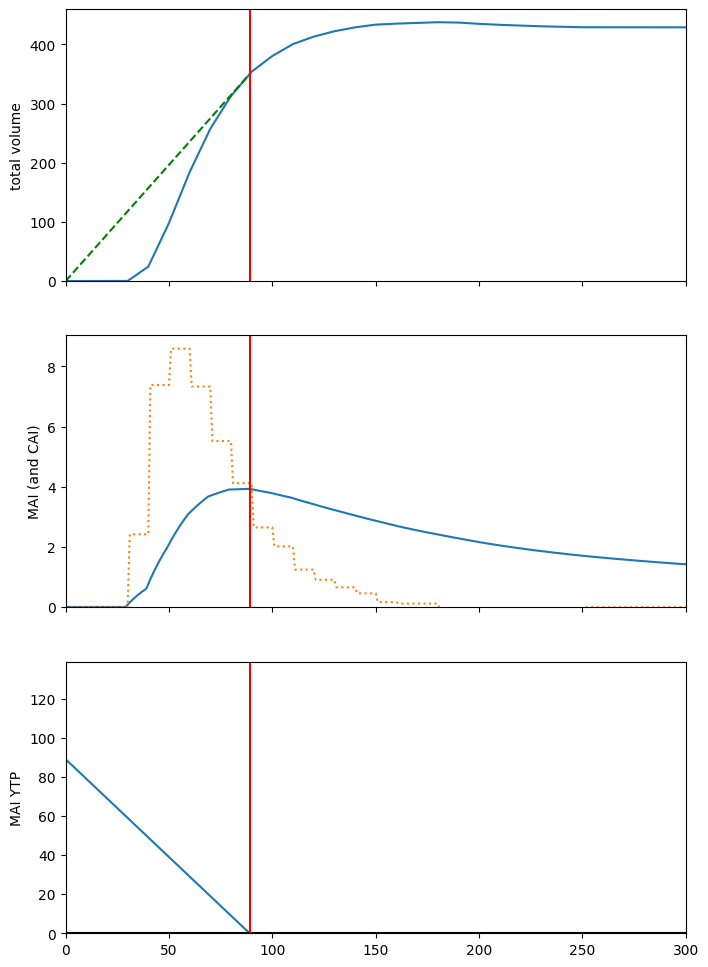

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)

Note that when setting up a new `ForestModel` instance, you have to stash a copy of _all_ the yield curves you need, _including the curves for development types that are not present in the intial inventory_ (`ws3` grabs a copy of these when JIt-building new `DevelopmentType` objects on the fly, only if induced by applying an action to an development type and the specified transition induces a new development type). 

All of this gets automatically set up correctly if you use the built-in functions to import Woostock-style input files, but is your responsibility if you bypass and direct-code your model.

In [30]:
len(fm.yields), fm.yields[0]

(49,
 (('?', '?', '2401000', '?', '2401000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7facf4bcb1f0>)]))

Have a look at the actions in the model.

In [31]:
fm.actions

{'harvest': <ws3.forest.Action at 0x7facf4be21d0>}

In [32]:
list(fm.transitions['harvest'].items())[:3]

[(('?', '?', '2402000', '?', '?'),
  {'': [(('?', '?', '?', '?', '2422000'),
     1.0,
     None,
     None,
     None,
     None,
     None)]}),
 (('?', '?', '2403000', '?', '?'),
  {'': [(('?', '?', '?', '?', '2423000'),
     1.0,
     None,
     None,
     None,
     None,
     None)]}),
 (('?', '?', '2403001', '?', '?'),
  {'': [(('?', '?', '?', '?', '2423001'),
     1.0,
     None,
     None,
     None,
     None,
     None)]})]

In [33]:
dt.oper_expr

defaultdict(list, {'harvest': ['totvol >= 50 and _age <= 500']})

In [34]:
dt.operability

{'harvest': {1: (43, 500),
  2: (43, 500),
  3: (43, 500),
  4: (43, 500),
  5: (43, 500),
  6: (43, 500),
  7: (43, 500),
  8: (43, 500),
  9: (43, 500),
  10: (43, 500)}}

In [35]:
list(dt.transitions.items())[:3]

[(('harvest', 43),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 44),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 45),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)])]

In [36]:
list(dt.transitions.items())[-3:]

[(('harvest', 498),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 499),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)]),
 (('harvest', 500),
  [(('?', '?', '?', '?', '2423002'), 1.0, None, None, None, None, None)])]

In [37]:
fm.dtypes

{('tsa24_clipped',
  '0',
  '2401000',
  '100',
  '2401000'): <ws3.forest.DevelopmentType at 0x7facf4bca230>,
 ('tsa24_clipped',
  '0',
  '2402005',
  '1201',
  '2402005'): <ws3.forest.DevelopmentType at 0x7facf4bcbca0>,
 ('tsa24_clipped',
  '1',
  '2401002',
  '204',
  '2401002'): <ws3.forest.DevelopmentType at 0x7facf4bcae00>,
 ('tsa24_clipped',
  '1',
  '2401002',
  '204',
  '2421002'): <ws3.forest.DevelopmentType at 0x7facf4bc8640>,
 ('tsa24_clipped',
  '1',
  '2402000',
  '100',
  '2402000'): <ws3.forest.DevelopmentType at 0x7facf4bcaef0>,
 ('tsa24_clipped',
  '1',
  '2402002',
  '204',
  '2402002'): <ws3.forest.DevelopmentType at 0x7facf4bca080>,
 ('tsa24_clipped',
  '1',
  '2403000',
  '100',
  '2403000'): <ws3.forest.DevelopmentType at 0x7facf4bc9780>,
 ('tsa24_clipped',
  '1',
  '2403002',
  '204',
  '2403002'): <ws3.forest.DevelopmentType at 0x7facf4bc9390>,
 ('tsa24_clipped',
  '1',
  '2403002',
  '204',
  '2423002'): <ws3.forest.DevelopmentType at 0x7facf4bca3e0>}

Get a reference to one of the managed (i.e., THLB) `DevelopmentType` instances we now have in `fm` (specifically, the `DevelopmentType` with key `('tsa24_clipped', '1', '2403002', '204', '2423002')`. We do this by _unmasking_ the `DevelopmentType` list using a mask string in Woodstock format, where the `?` represents a wildcard. Refer to the `ws3` documentation for a more in-depth explanation of theme and masks and development types and such (this documentation is a WIP so this may not be clearly documented yet). 

In [38]:
dtk = fm.unmask('? 1 ? ? ?').pop()
dtk

('tsa24_clipped', '1', '2403002', '204', '2423002')

In [39]:
dt = fm.dtypes[dtk]
dt.key

('tsa24_clipped', '1', '2403002', '204', '2423002')

Inspect the `_areas` private attribute of the `DevelopmentType` instance we grabbed. This data structure stores the _inventory_ for the parent `DevelopmentType` (i.e., area by period and ageclass). 

At this point in the modelling process, we have only defined the _initial inventory_ in period 0. The other periods get populated later when we initialize the period-1 inventory and simulated growth and actions (which we have not done yet).

In [40]:
dt._areas

{0: defaultdict(float, {9: 59.81429119367274, 18: 32.366198551219505}),
 1: defaultdict(float, {}),
 2: defaultdict(float, {}),
 3: defaultdict(float, {}),
 4: defaultdict(float, {}),
 5: defaultdict(float, {}),
 6: defaultdict(float, {}),
 7: defaultdict(float, {}),
 8: defaultdict(float, {}),
 9: defaultdict(float, {}),
 10: defaultdict(float, {})}

You can see that initial inventory for this `DevelopementType` contains 59.8 hectares in ageclass 9 and 32.4 hectares in ageclass 18). 

Below, we should how you can access this same information using the public interfaces built into the `DevelopmentType` and `ForestModel` classes.

In [41]:
dt.area(period=0) # total inventory area in period 0

92.18048974489224

In [42]:
acd = fm.age_class_distribution(0, mask=dt.key, omit_null=True)
acd

{9: 59.81429119367274, 18: 32.366198551219505}

In [43]:
for age in acd:
    print(age, dt.area(period=0, age=age)) # ageclass 9 inventory area in period 0

9 59.81429119367274
18 32.366198551219505


## Implement a priority queue harvest scheduling heuristic

Below we define a function that implements a old-stand-first priority queue harvest scheduling heuristic. To make this demo as n00b friends as possible, we set this up to be self-parametrising, i.e., the model automatically figures out an appropriate "periodic harvest area target" parameter value, by analysing the shape of its own yield curves to estimate a landscape-level optimal rotation age.

In [44]:
def schedule_harvest_areacontrol(fm, period=1, acode='harvest', util=0.85, 
                                 target_masks=None, target_areas=None, target_scalefactors=None,
                                 mask_area_thresh=0.,
                                 verbose=0):
    if not target_areas:
        if not target_masks: # default to AU-wise THLB 
            au_vals = []
            au_agg = []
            for au in fm.theme_basecodes(2):
                mask = '? 1 %s ? ?' % au
                masked_area = fm.inventory(0, mask=mask)
                if masked_area > mask_area_thresh:
                    au_vals.append(au)
                else:
                    au_agg.append(au)
                    if verbose > 0:
                        print('adding to au_agg', mask, masked_area)
            if au_agg:
                fm._themes[2]['areacontrol_au_agg'] = au_agg 
                if fm.inventory(0, mask='? ? areacontrol_au_agg ? ?') > mask_area_thresh:
                    au_vals.append('areacontrol_au_agg')
            target_masks = ['? 1 %s ? ?' % au for au in au_vals]
        target_areas = []
        for i, mask in enumerate(target_masks): # compute area-weighted mean CMAI age for each masked DT set
            masked_area = fm.inventory(0, mask=mask, verbose=verbose)
            if not masked_area: continue
            r = sum((fm.dtypes[dtk].ycomp('totvol').mai().ytp().lookup(0) * fm.dtypes[dtk].area(0)) for dtk in fm.unmask(mask))
            r /= masked_area
            asf = 1. if not target_scalefactors else target_scalefactors[i]  
            ta = (1/r) * fm.period_length * masked_area * asf
            target_areas.append(ta)
    for mask, target_area in zip(target_masks, target_areas):
        if verbose > 0:
            print('calling areaselector', period, acode, target_area, mask)
        fm.areaselector.operate(period, acode, target_area, mask=mask, verbose=verbose)
    sch = fm.compile_schedule()
    return sch

In [45]:
def plot_results(fm):
    pareas = [fm.compile_product(period, '1.') for period in fm.periods]
    pvols = [fm.compile_product(period, 'totvol') for period in fm.periods]
    df = pd.DataFrame({'period':fm.periods, 'ha':pareas, 'hv':pvols})
    fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
    ax[0].set_ylabel('harvest area')
    ax[0].bar(df.period, df.ha)
    ax[1].set_ylabel('harvest volume')
    ax[1].bar(df.period, df.hv)
    ax[2].set_ylabel('harvest volume:area ratio')
    ax[2].bar(df.period, (df.hv/df.ha).fillna(0))
    ax[2].set_ylim(0, None)
    return fig, ax, df

In [46]:
fm.reset()

In [47]:
verbose = False # flip to True if you want the harvest scheduler to get _really_ chatty while it works
for period in fm.periods:
    schedule_harvest_areacontrol(fm, period=period, verbose=verbose)

(<Figure size 800x1200 with 3 Axes>,
 array([<Axes: ylabel='harvest area'>, <Axes: ylabel='harvest volume'>,
        <Axes: ylabel='harvest volume:area ratio'>], dtype=object),
    period          ha            hv
 0       1  114.414757  18411.708057
 1       2  112.170767  18092.104568
 2       3  112.170767  18181.160976
 3       4  122.780259  18809.860267
 4       5  122.780259  19621.399427
 5       6  122.780259  20899.681994
 6       7  122.780259  21241.080708
 7       8  122.780259  22268.967941
 8       9  121.454976  20896.539070
 9      10  109.377814  12912.235074)

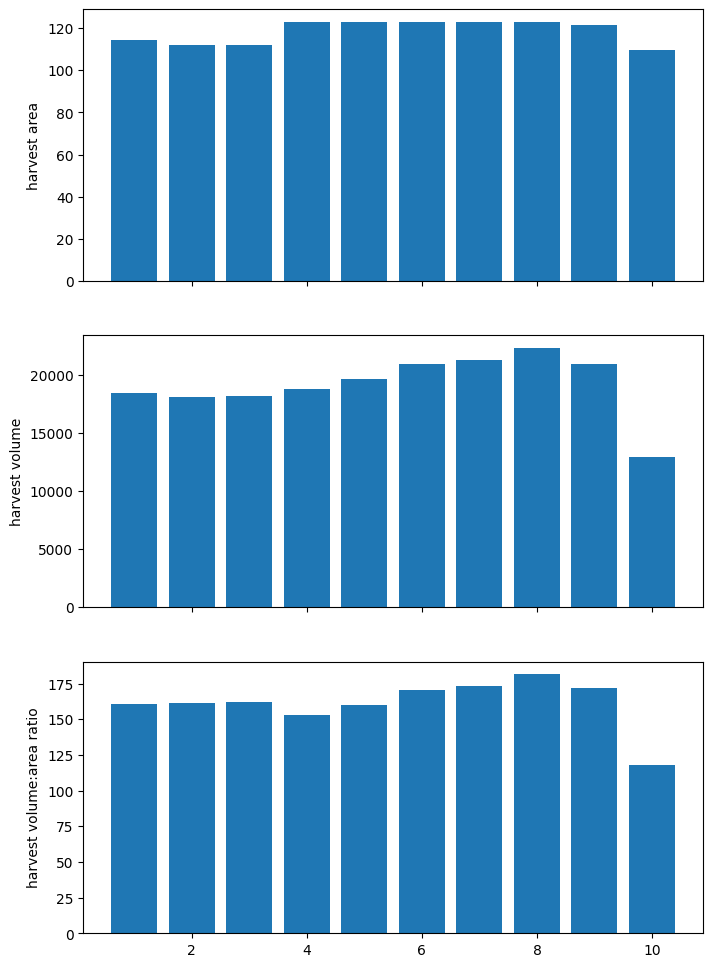

In [48]:
plot_results(fm)

Not bad for a simplistic priority queue heuristic! Using the default `ws3.forest.GreedyAreaSelector` class to select harvest areas is definitely not the only way to simulate harvesting in `ws3`. 

You can always _manually prescribe_ any combination of treatments in any period, and `ws3` will its best to comply. By default `ws3` has several layers of fault protection turned on to avoid crashing with angry-looking error messages every time a user prescribes an invalid action. 

## Implement some manually prescribed harvest actions

Below we reset the `fm` instance (which resets applied actions and inventory to starting positions), the manually prescribe a harvesting actions (using our sample `DevelopmentType` instance from earlier as the target, just as an example). 

First, we try to harvest 1.0 hectare of age 9 stands in period 1.

In [49]:
fm.reset()
fm.apply_action(dtype_key=dt.key, 
                acode='harvest', 
                period=1,
                age=9,
                area=1.0)

not operable
tsa24_clipped 1 2403002 204 2423002 harvest 1 9
(43, 500)


(4, None, None)

No good. Not operable. Also not surprizing, given that we defined harvest operability window to start at age 40 for all development types.

We can use the `operable_dtypes` method to find a suitable target for our harvesting action.

In [50]:
fm.operable_dtypes(acode='harvest', period=1)

{('tsa24_clipped', '1', '2401002', '204', '2401002'): [135,
  105,
  155,
  78,
  80,
  113,
  145,
  115,
  85,
  125,
  153,
  91,
  93,
  95],
 ('tsa24_clipped', '1', '2402000', '100', '2402000'): [165],
 ('tsa24_clipped', '1', '2402002', '204', '2402002'): [115, 93, 78, 95],
 ('tsa24_clipped', '1', '2403000', '100', '2403000'): [93],
 ('tsa24_clipped', '1', '2403002', '204', '2403002'): [73]}

In [51]:
fm.operable_area(acode='harvest', period=5, age=40)

0.0

How much area is operable for development type `('tsa24_clipped', '1', '2401002', '204', '2401002')` age 135 in period 1?

In [52]:
fm.operable_area(acode='harvest', period=1, age=135)

72.24421919373785

Harvest 50 ha of that.

In [53]:
fm.apply_action(dtype_key=('tsa24_clipped', '1', '2401002', '204', '2401002'), 
                acode='harvest', 
                period=1,
                age=135,
                area=50.,
                compile_c_ycomps=True)

(0, 0.0, [[('tsa24_clipped', '1', '2401002', '204', '2421002'), 1.0, 0]])

Note that the way we set this model up, the actionned area transitions to develoment type `('tsa24_clipped', '1', '2401002', '204', '2421002')`, which corresponds to second-growth yield curve (as opposed to the first-growth yield curve the area was originally tracking along). We will look for this second-growth development type key below and try to harvest it a second time.

Commit the action. Just roll with it. Normally `ws3` takes care of committing actions at appropriate moments, but you have to do this yourself when running in fully manual mode (like we are doing now).

In [54]:
fm.commit_actions(period=1)

Check the new operable area.

In [55]:
fm.operable_area(acode='harvest', period=1, age=135)

22.244219193737848

22.2 operable ha left. Makes sense.

So, we know that our previously harvested area transitions to development type `('tsa24_clipped', '1', '2401002', '204', '2421002')`. 

We can query the development type object about its period-wise operability.

In [56]:
dtk = ('tsa24_clipped', '1', '2401002', '204', '2421002')
dt = fm.dtypes[dtk]
dt.operability

{'harvest': {1: (80, 500),
  2: (80, 500),
  3: (80, 500),
  4: (80, 500),
  5: (80, 500),
  6: (80, 500),
  7: (80, 500),
  8: (80, 500),
  9: (80, 500),
  10: (80, 500)}}

We can see that it become operable at age 80.

If we inspect the private `_areas` attribute of the develoment type, we can see that there is 0.42 ha of age-20 area in the initial inventory, and a new 50.0 ha that gets created from our harvest action (which is

In [57]:
dt._areas

{0: defaultdict(float, {20: 0.422054121206099}),
 1: defaultdict(float, {20: 0.422054121206099, 0: 50.0}),
 2: defaultdict(float, {30: 0.422054121206099, 10: 50.0}),
 3: defaultdict(float, {40: 0.422054121206099, 20: 50.0}),
 4: defaultdict(float, {50: 0.422054121206099, 30: 50.0}),
 5: defaultdict(float, {60: 0.422054121206099, 40: 50.0}),
 6: defaultdict(float, {70: 0.422054121206099, 50: 50.0}),
 7: defaultdict(float, {80: 0.422054121206099, 60: 50.0}),
 8: defaultdict(float, {90: 0.422054121206099, 70: 50.0}),
 9: defaultdict(float, {100: 0.422054121206099, 80: 50.0}),
 10: defaultdict(float, {110: 0.422054121206099, 90: 50.0})}

We can use the `operable_ages` method to find the first period in which it become operable.

In [58]:
for p in fm.periods: 
    print('period:', p, 
          'operable ages:', dt.operable_ages('harvest', p),
          'operable area:', dt.operable_area('harvest', p))

period: 1 operable ages: [] operable area: 0.0
period: 2 operable ages: [] operable area: 0.0
period: 3 operable ages: [] operable area: 0.0
period: 4 operable ages: [] operable area: 0.0
period: 5 operable ages: [] operable area: 0.0
period: 6 operable ages: [] operable area: 0.0
period: 7 operable ages: [80] operable area: 0.422054121206099
period: 8 operable ages: [90] operable area: 0.422054121206099
period: 9 operable ages: [80, 100] operable area: 50.4220541212061
period: 10 operable ages: [90, 110] operable area: 50.4220541212061


So, the 50 ha of area we previously harvested does not become operable again until period 9.

Try to harvest the same area (now tracking along a second-growth yield curve) a second time.

In [59]:
fm.apply_action(dtype_key=dtk, 
                acode='harvest', 
                period=9,
                age=80,
                area=50.,
                compile_c_ycomps=True)

(0, 0.0, [[('tsa24_clipped', '1', '2401002', '204', '2421002'), 1.0, 0]])

In [60]:
fm.commit_actions(period=9)

Plot results.

(<Figure size 800x1200 with 3 Axes>,
 array([<Axes: ylabel='harvest area'>, <Axes: ylabel='harvest volume'>,
        <Axes: ylabel='harvest volume:area ratio'>], dtype=object),
    period    ha       hv
 0       1  50.0  7458.25
 1       2   0.0     0.00
 2       3   0.0     0.00
 3       4   0.0     0.00
 4       5   0.0     0.00
 5       6   0.0     0.00
 6       7   0.0     0.00
 7       8   0.0     0.00
 8       9  50.0  2382.50
 9      10   0.0     0.00)

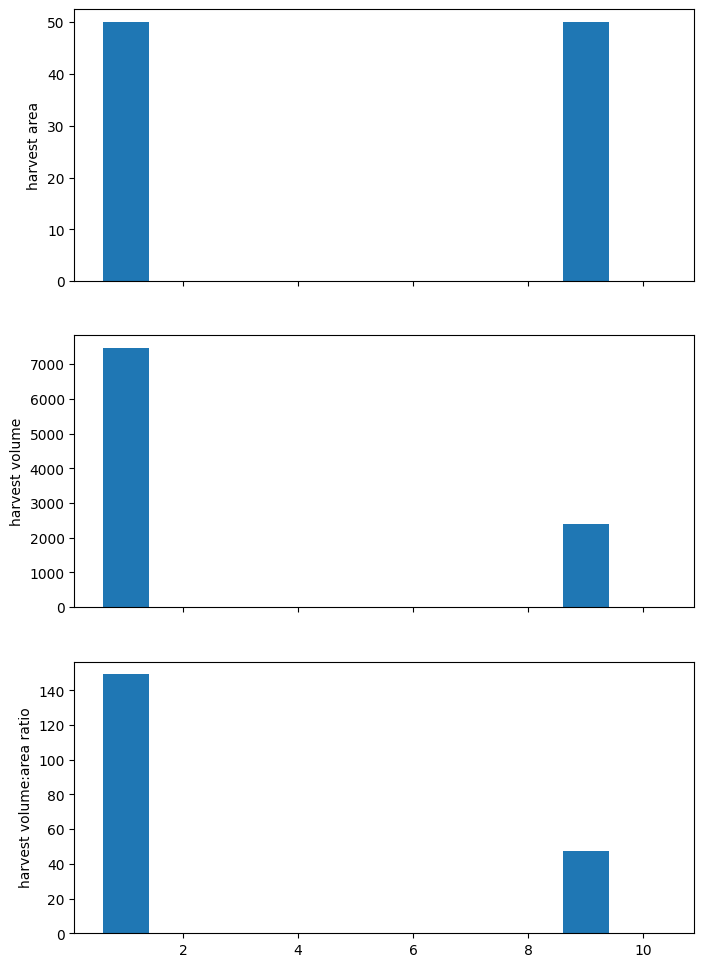

In [61]:
plot_results(fm)

Note that you would rarely (if ever) need to be poking around the guts of your `ws3` model in this way just to schedule some harvesting treatments. The point of the stuff above is to help you understand some of the basic action scheduling and action operability functions (and where the bit live in the `ws3` data model), which in turn are the building blocks of all the higher-level scheduling functions in ws3. 

If you like, take some time now to go have a closer look at the source code for the `GreedyAreaSelector` class in (defined in the `ws3.forest` module). If you look closely, you will see that it is basically just combining all the bit we used in our random-seeming example above (i.e., `operable_dtypes`, `operable_area`, `apply_action`, `commit_actions`), glued together with some `while` loops and `if` conditions and other stuff. Neat, right? 

If you wanted to, you could write your own `AreaSelector` class that uses different logic to select and operate on area in your model (as long as your class has an `__init__` method that sets a `parent` attribute that points back to your `ForestModel` instance and an `operate` method with appropriate args, it should work). You can monkey-patch the `ForestModel.areaselector` attribute at runtime to change the default behaviour of your model as well (several of the fault-recovery functions in the `ForestModel` class use the `areaselector` to find operable area when the things go a bit pear-shaped and you have set up the model to do its best to find operable area and keep going when part of the prescribed action schedule is infeasible). See `ForestModel.repair_actions`, `ForestModel.commit_actions`, `ForestModel.apply_action`, and `ForestModel.apply_schedule` for examples of where the `areaselector` gets used to smooth over bumps in the road.

## Implement optimization-based action scheduling

`ws3` also includes functions to automate the process of formulating and solving linear programming (LP) optimization problems to schedule actions in your model. Using an optimization approach, you formulate your forest-level management problem in terms of an _objective function_ and _constraints_.

`ws3` currently includes functions to formulate and solve Model I type optimization problems, as first documented in Johson and Scheurman (1977).

>Johnson, K.N. and H.L. Scheurman (1977). “Techniques for prescribing optimal
timber harvest and investment under different objectives—discussion and
synthesis”. In: Forest Science Monograph 23.suppl_1.



The optimization problem can be formulated as follows


\begin{align}
  \text{max} \quad &  \sum_{i\in I}\sum_{j \in J_{i}}c_{ij}x_{ij} & \label{eq:z}\\
  \text{s.t.} \quad & \nonumber \\
   &(1-\varepsilon_{p})y_p \leq \sum_{i\in I}\sum_{j\in J_{i}}\mu_{ijpt}x_{ij}  \leq  (1+\varepsilon_{p})y_p, & \forall p\in O', t\in T'_p \label{eq:constr_evenflow}\\
   &v^{-}_{ot}\leq\sum_{i\in Z}\sum_{j\in J_{i}}\mu_{ijot}x_{ij}  \leq v^{+}_{ot}, &  \forall o\in O, t\in T \label{eq:constr_general} \\
   &\sum_{j\in J_{i}}x_{ij}  = 1, \forall i\in Z \label{eq:constr_coverage} \\
   &0 \leq x_{ij} \leq 1, & \forall i \in Z, j \in J_{i} \label{eq:constr_bounds}
\end{align}

where

\begin{align*}
  I := & \,\, \text{set of spatial zones}\\
  J_{i} := & \,\, \text{set of available prescriptions for zone $i \in I$}\\
  O := & \,\, \text{set of forest outputs}\\
  O' \subseteq O := & \,\, \text{set of targeted forest outputs}\\
  T := & \,\, \text{set of time periods in the planning horizon}\\
  T'_p \subseteq O := & \,\, \text{subset of $T$ on which even-flow constraints for output $p \in O^{\prime}$ are applied}\\
  \varepsilon_{p} := & \,\, \text{admissible level of variation on yield of targeted output $p \in O^{\prime}$} \\
  \mu_{ijot} := & \,\, \text{quantity of output $o \in O$ produced in period $t \in T$ by prescription $j \in J_{i}$}\\
                     & \,\, \text{in zone $i \in I$}\\
  \mu_{ijpt} := & \,\, \text{quantity of output $p \in O'$ produced in period $t \in T$ by prescription $j \in J_{i}$}\\
                     & \,\, \text{in zone $i \in I$}\\
  v^{-}_{ot} := & \,\, \text{lower bound on yield of output $o \in O$ in period $t \in T$} \\
  v^{+}_{ot} := & \,\, \text{upper bound on yield of output $o \in O$ in period $t \in T$} \\
  c_{ij} := & \,\,  \text{objective function contribution of prescription $j \in J_{i}$ in zone $i \in I$} \\
  x_{ij} := & \,\, \text{proportion of zone $i \in Z$ on which prescription $j \in J_{i}$ is applied} \\
  y_p = &  \sum_{i\in I}\sum_{j\in J_i}\mu_{ijpt^R_p}x_{ij}\text{, i.e. total yield of targeted output $p \in O'$ at reference period $t^R_p$} 
\end{align*}

The objective function maximizes the sum of $c_{ij}x_{ij}$ products, which represent yield of a user-defined output---the output can be anything, but common examples include maximizing harvest volume or minimizing harvest area. Other, more complex objectives functions can be defined (e.g., minimize a penalty-based weighted multi-objective goal programming objective function).

The variables $x_{ij}$ are linear, with domain $\{x_{ij} \in \mathbb{R}|0 \leq x_{ij} \leq 1\}$. Coverage constraints require prescriptions to cover the entire zone---doing nothing for the entire planning horizon is considered a prescription that could generate some outputs. Variable bounds and coverage constraints are automatically set by the `ws3` optimization problem formulation functions.


The set $O^{\prime} \subseteq O$ represents targeted outputs, for which we enforce even-flow constraints.
Even-flow constraints are expressed in terms of $y_p$, which represents total yield of targeted output $p \in O^{\prime}$ in reference period $t^R_p$.
Note that even-flow constraints are defined over time periods $T'_p$, which is any subset of $T$ (need not be contiguous)---$T'_p$ can be unique for each output  $p \in O^{\prime}$.

General constraints set upper and lower bounds on periodic yield of any output $o \in O$---we use these constraints to set minimum and maximum levels of any performance indicator defined in the model (or combinations thereof). 

Below we show an example of using the optimization functins in `ws3` to formulate and solve a Model I probleml.

You will need to have `gurobipy` installed for this next step to work. At some point I will finish implementing bindings to the PuLP open-source solver library, but for now we are stuck with Gurobi as the only solver that works with ws3. 

You should be able to install `gurobipy` using the magic `%pip` command below, however this _only_ installs the Python module and minimal solver binaries. This _does not_ install the full Gurobi software stack, do the Gurobi licence managent tools (including the `grbgetkey` command) are _not_ installed automatically with the Python module. The `gurobipy` installation includes a limited software license that should allow you to solve _small_ problem instances, but will puke if you try to solve anything too large (which includes most `ws3` problems, unless you model is extremely small and simple). 

If you are eligible for an academic license, you should request and install a "Named-User Acacdemic" license from the Licenses tab in the [Gurobi User Portal](https://portal.gurobi.com/iam/licenses/request) (create a new Gurobi account if you do not have one yet, using your official academic institution email address). This license is per-user, per-machine, is valid for one year, should _only_ be used in an academic context (see [Gurobi Standard EULA](https://cdn.gurobi.com/wp-content/uploads/Gurobi_Standard_EULA_Nov2022.pdf) for details of license terms and restrictions).

**Hint:** If you get a `grbgetkey: command not found` error, either the full Gurobi software stack is not installed at all on your system, or is installed but `grbgetkey` is not in your path. Depending on your situation, either [install the full Gurobi software stack](https://support.gurobi.com/hc/en-us/articles/4534161999889) or specify the full path to the `grbgetkey` command (Gurobi installation instructions recommend installing Gurobi into `/opt/gurobi` on linux platforms).   

In [62]:
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [63]:
import gurobipy as grb

First we need to define a few utility functions that we will use to build the problems (e.g., objective function coefficient function, even flow constraint coefficient function, general constraint coefficient function).

Note that the `spades_ws3` project contains several useful chunks of code that you can use as a starting point (on GitHub, see link below).

https://github.com/gparadis/spades_ws3/blob/master/python/spadesws3.py

In [64]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem.

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [65]:
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, cgen_gs={}, 
                 tvy_name='totvol', obj_mode='max_hv', mask=None):
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_ha': # minimize harvest area
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = '1.'
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)        
    coeff_funcs['z'] = partial(cmp_c_z, expr=zexpr) # define objective function coefficient function  
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

Define functions to compile scenario output into a dataframe, and plot this data.

In [66]:
def compile_scenario(fm):
    oha = [fm.compile_product(period, '1.', acode='harvest') for period in fm.periods]
    ohv = [fm.compile_product(period, 'totvol * 0.85', acode='harvest') for period in fm.periods]
    ogs = [fm.inventory(period, 'totvol') for period in fm.periods]
    data = {'period':fm.periods, 
            'oha':oha, 
            'ohv':ohv, 
            'ogs':ogs}
    df = pd.DataFrame(data)
    return df

In [67]:
def plot_scenario(df):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].bar(df.period, df.oha)
    ax[0].set_ylim(0, None)
    ax[0].set_title('Harvested area (ha)')
    ax[1].bar(df.period, df.ohv)
    ax[1].set_ylim(0, None)
    ax[1].set_title('Harvested volume (m3)')
    ax[2].bar(df.period, df.ogs)
    ax[2].set_ylim(0, None)
    ax[2].set_title('Growing Stock (m3)')
    return fig, ax

We need to add a "null" action to the model for the optimization functions to work correctly. This is basically a pass-through action that literally does nothing (i.e., just grow the forest for one time step, which `ws3` models as an explicit decision option in the dynamic programming state trees it builds when it generates the LP problem matrix).

In [68]:
fm.add_null_action()

We define some scenario options below. Specify which scenario by setting the `scenario_name` variable below.

In [69]:
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    
    # define harvest area and harvest volume flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)

    if scenario_name == 'base': 
        # Base scenario
        print('running bsae scenario')
    elif scenario_name == 'base-cgen_ha': 
        # Base scenario, plus harvest area general constraints
        print('running base scenario plus harvest area constraints')
        cgen_ha = {'lb':{1:100.}, 'ub':{1:101.}}    
    elif scenario_name == 'base-cgen_hv': 
        # Base scenario, plus harvest volume general constraints
        print('running base scenario plus harvest volume constraints')
        cgen_hv = {'lb':{1:1000.}, 'ub':{1:1001.}}    
    elif scenario_name == 'base-cgen_gs': 
        # Base scenario, plus growing stock general constraints
        print('running base scenario plus growing stock constraints')
        cgen_gs = {'lb':{10:100000.}, 'ub':{10:100001.}}
    else:
        assert False # bad scenario name

    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs)

    fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        sys.exit()
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    return fig, df, p

Note that the `Problem.solve` method return a reference to the lower-level `gurobi.Model` object in case we need or want to poke around it (can yield insight into how the optimization problem is formulated on the solver side of things, or help debug).

Be vigilant for "infeasible or unbounded model" messages and such below, in case these are unexpected. Depending on how the rest of the model was set up, `ws3` may automatically attempt to resolve infeasible models using "feasibility relaxation" mode in Gurobi (which might not be what you want, depending on the situation).

running bsae scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 72 rows, 320 columns and 3528 nonzeros
Model fingerprint: 0xaef7bd8f
Coefficient statistics:
  Matrix range     [3e-02, 4e+04]
  Objective range  [2e+01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 12 rows and 32 columns
Presolve time: 0.01s
Presolved: 60 rows, 288 columns, 3280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1445645e+05   1.046982e+04   0.000000e+00      0s
      79    1.8837161e+05   0.000000e+00   0.000000e+00      0s

Solved in 79 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.883716077e+05
foo


(<Figure size 1200x400 with 3 Axes>,
    period         oha           ohv            ogs
 0       1  141.884536  18776.518275  129802.193269
 1       2  134.790309  17837.692361  122458.829271
 2       3  134.790309  17837.692361  113354.435725
 3       4  134.790309  17837.692361  104521.374438
 4       5  134.790309  18086.166885   96456.943325
 5       6  134.790309  19715.344189   85374.110687
 6       7  147.721253  19715.344189   72562.743824
 7       8  135.688774  19715.344189   59660.980420
 8       9  148.978762  19134.468737   49258.413311
 9      10  148.978762  19715.344189   37323.465085,
 <ws3.opt.Problem at 0x7fad5594b850>)

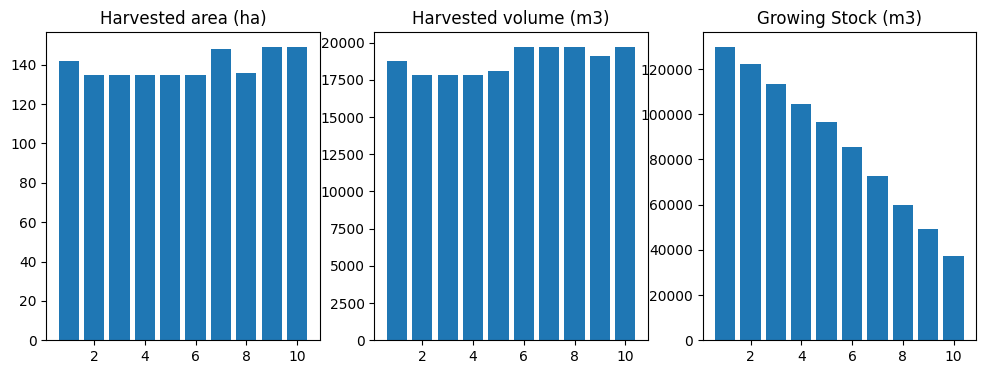

In [70]:
run_scenario(fm, 'base')

running base scenario plus harvest area constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 74 rows, 320 columns and 3636 nonzeros
Model fingerprint: 0x0c856e46
Coefficient statistics:
  Matrix range     [3e-02, 4e+04]
  Objective range  [2e+01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 13 rows and 32 columns
Presolve time: 0.01s
Presolved: 61 rows, 289 columns, 3335 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1445645e+05   1.084514e+04   0.000000e+00      0s
     242    1.5442772e+05   0.000000e+00   0.000000e+00      0s

Solved in 242 iterations and 0.02 seconds (0.00 work units)
Optimal objective  1.544277197e+05
foo


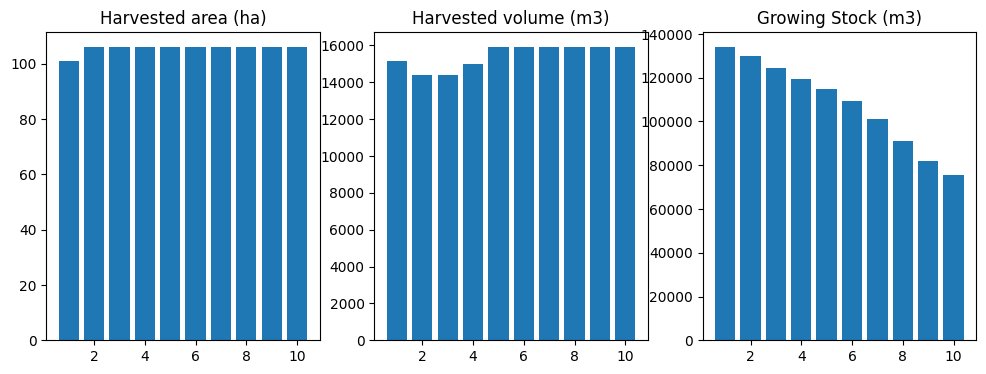

In [71]:
fig, df, problem = run_scenario(fm, 'base-cgen_ha')

running base scenario plus harvest volume constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 74 rows, 320 columns and 3636 nonzeros
Model fingerprint: 0x5f22a9da
Coefficient statistics:
  Matrix range     [3e-02, 4e+04]
  Objective range  [2e+01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 13 rows and 32 columns
Presolve time: 0.01s
Presolved: 61 rows, 289 columns, 3335 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1445645e+05   1.251252e+04   0.000000e+00      0s
     185    1.0460450e+04   0.000000e+00   0.000000e+00      0s

Solved in 185 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.046045000e+04
foo


(<Figure size 1200x400 with 3 Axes>,
    period       oha      ohv            ogs
 0       1  8.331899  1001.00  150714.567710
 1       2  7.915304  1051.05  163551.173675
 2       3  7.915304  1051.05  175087.625303
 3       4  7.915304  1051.05  187399.534057
 4       5  7.915304  1051.05  201267.693396
 5       6  7.915304  1051.05  214065.588205
 6       7  8.183842  1051.05  224115.909147
 7       8  7.915304  1051.05  231291.165658
 8       9  8.748494  1051.05  235955.108909
 9      10  8.246498  1051.05  238263.751015,
 <ws3.opt.Problem at 0x7fad1b600c40>)

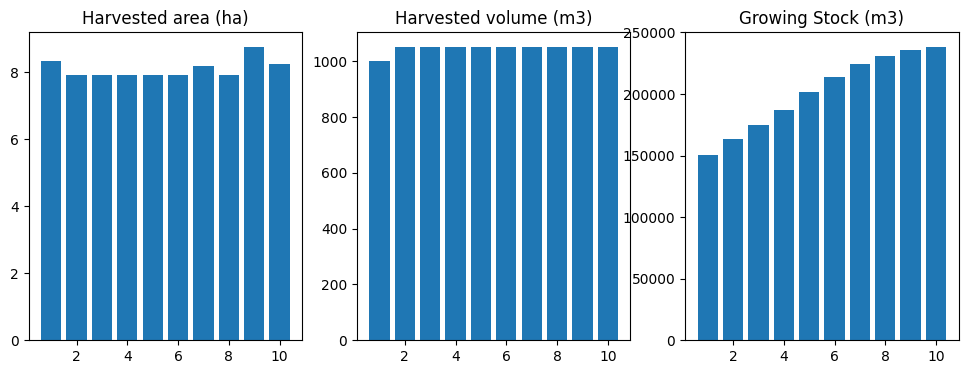

In [72]:
run_scenario(fm, 'base-cgen_hv')

running base scenario plus growing stock constraints
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 74 rows, 320 columns and 3864 nonzeros
Model fingerprint: 0xc845457e
Coefficient statistics:
  Matrix range     [3e-02, 5e+04]
  Objective range  [2e+01, 4e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 13 rows and 8 columns
Presolve time: 0.01s
Presolved: 61 rows, 313 columns, 3465 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1445645e+05   1.075994e+04   0.000000e+00      0s
      72    1.4428824e+05   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.442882425e+05
foo


(<Figure size 1200x400 with 3 Axes>,
    period         oha           ohv            ogs
 0       1  106.640924  14646.316708  134661.253936
 1       2  111.972970  15378.632543  129044.775063
 2       3  101.308877  15378.632543  121944.806149
 3       4  102.438937  13914.000872  117292.135690
 4       5  104.616660  13914.000872  114596.572361
 5       6  105.884376  13914.000872  112543.129513
 6       7  104.331548  13914.000872  110694.825305
 7       8  102.939333  13914.000872  108208.374438
 8       9  101.308877  13936.023847  105065.815415
 9      10  109.697391  15378.632543  100000.000000,
 <ws3.opt.Problem at 0x7facf26a82b0>)

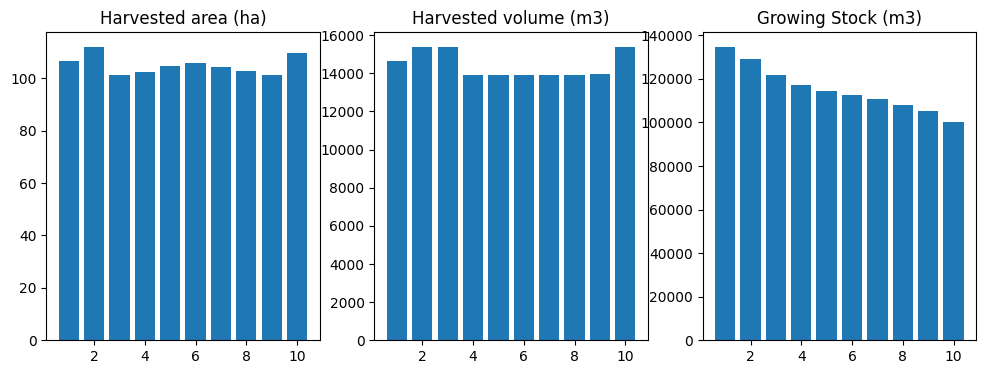

In [73]:
run_scenario(fm, 'base-cgen_gs')

Ta da!

Start by creating a new directory to hold the model definition files.

In [74]:
!mkdir data/woodstock_model_files

mkdir: cannot create directory ‘data/woodstock_model_files’: File exists


Woodstock models are defined in terms of a number of _sections_. The sections can be defined in a single text file, or in separate text files. We will use separate text files for each section in this example.

Our model will include the following sections:

LANDSCAPE
AREAS
YIELD
ACTIONS
TRANSITIONS

There are other possible sections that one can include in a Woodstock model, which will not include here. This is not intended to be a comprehensive overview of Woodstock-format model definition. Refer to the Woodstock technical documentation for the complete story.

## `LANDSCAPE` section

The `LANDSCAPE` section defines themes (i.e., state variables), theme basecodes (i.e., valid state variable values), and theme aggregates (i.e., groups of state variable values within a given theme, which can include aggregates with no [documented] limit on recursion depth).

We can start by printing `fm._theme_basecodes`, to provide a "cheat sheet" for the values we need to code into the `LANDSCAPE` section of our Woodstock model definition.

In [75]:
fm._theme_basecodes

[['tsa24_clipped'],
 ['1', '0'],
 ['2402002',
  '2403000',
  '2402005',
  '2401006',
  '2401000',
  '2402006',
  '2401007',
  '2403002',
  '2402003',
  '2402004',
  '2401002',
  '2401003',
  '2403004',
  '2402007',
  '2403007',
  '2403006',
  '2402001',
  '2403005',
  '2402000',
  '2401005',
  '2401001',
  '2403001',
  '2401004',
  '2403003'],
 ['304', '204', '104', '1201', '100'],
 ['2402002',
  '2403000',
  '2423000',
  '2423001',
  '2402005',
  '2401006',
  '2401000',
  '2423004',
  '2422000',
  '2421002',
  '2402006',
  '2403002',
  '2401007',
  '2402003',
  '2402004',
  '2422007',
  '2401002',
  '2423003',
  '2401003',
  '2403004',
  '2402007',
  '2403007',
  '2423007',
  '2403006',
  '2423002',
  '2421007',
  '2422004',
  '2402001',
  '2403005',
  '2402000',
  '2422002',
  '2401005',
  '2401001',
  '2403001',
  '2401004',
  '2422003',
  '2403003']]

Print the THEME values to a format that we can easily copy and past into our text file to speed up coding this up.

In [76]:
for v in fm._theme_basecodes[2]: print(v)

2402002
2403000
2402005
2401006
2401000
2402006
2401007
2403002
2402003
2402004
2401002
2401003
2403004
2402007
2403007
2403006
2402001
2403005
2402000
2401005
2401001
2403001
2401004
2403003


In [77]:
for v in fm._theme_basecodes[3]: print(v)

304
204
104
1201
100


In [78]:
for v in fm._theme_basecodes[4]: print(v)

2402002
2403000
2423000
2423001
2402005
2401006
2401000
2423004
2422000
2421002
2402006
2403002
2401007
2402003
2402004
2422007
2401002
2423003
2401003
2403004
2402007
2403007
2423007
2403006
2423002
2421007
2422004
2402001
2403005
2402000
2422002
2401005
2401001
2403001
2401004
2422003
2403003


In [79]:
landscape_section = \
"""
*THEME Timber Supply Area (TSA)
tsa24_clipped

*THEME Timber Harvesting Land Base (THLB)
0
1

*THEME Analysis Unit (AU)
2402002
2401007
2402001
2401005
2402000
2403004
2403006
2401004
2401006
2402004
2402007
2403005
2401002
2403007
2403003
2401000
2402005
2402006
2401003
2403002
2402003
2403000
2401001
2403001

*THEME Leading tree species (CANFI species code)
304
100
1201
204
104

*THEME Yield curve ID
2402002
2401007
2422007
2402001
2401005
2422003
2402000
2403004
2423004
2403006
2421007
2423003
2401004
2401006
2402004
2421002
2422004
2423002
2422002
2402007
2403005
2401002
2403007
2423007
2403003
2401000
2402005
2402006
2401003
2423001
2403002
2402003
2422000
2403000
2401001
2423000
2403001
"""

In [80]:
with open('data/woodstock_model_files/tsa24_clipped.lan', 'w') as f: f.write(landscape_section)

## `AREAS` section

The `AREAS` section defines the initial inventory, as area by development type and age. 

Rather can manually code this section (which would be long and also prone to user error), we can use a bit of code to print the required information in the correct format (which we can then copy and paste).

In [81]:
for name, group in gstands:
    dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
    print('*A', ' '.join(v for v in dtk), age, area)

*A tsa24_clipped 0 2401000 100 2401000 85 15.182274886309896
*A tsa24_clipped 0 2401000 100 2401000 95 20.653788842921458
*A tsa24_clipped 0 2401000 100 2401000 105 1.109374490200082
*A tsa24_clipped 0 2401000 100 2401000 125 25.73174833461312
*A tsa24_clipped 0 2401000 100 2401000 135 62.02382759721078
*A tsa24_clipped 0 2401000 100 2401000 145 45.32228954967691
*A tsa24_clipped 0 2401000 100 2401000 155 3.052804424896181
*A tsa24_clipped 0 2402005 1201 2402005 85 1.812979326195168
*A tsa24_clipped 1 2401002 204 2401002 78 103.76740323520823
*A tsa24_clipped 1 2401002 204 2401002 80 4.173147018452507
*A tsa24_clipped 1 2401002 204 2401002 85 282.1296355046733
*A tsa24_clipped 1 2401002 204 2401002 91 73.1021561503533
*A tsa24_clipped 1 2401002 204 2401002 93 28.37956666951611
*A tsa24_clipped 1 2401002 204 2401002 95 94.94675966211176
*A tsa24_clipped 1 2401002 204 2401002 105 32.175418531537815
*A tsa24_clipped 1 2401002 204 2401002 113 4.184826329641321
*A tsa24_clipped 1 2401002 20

In [82]:
areas_section = \
"""
*A tsa24_clipped 0 2401000 100 2401000 85 15.182274886309896
*A tsa24_clipped 0 2401000 100 2401000 95 20.653788842921458
*A tsa24_clipped 0 2401000 100 2401000 105 1.109374490200082
*A tsa24_clipped 0 2401000 100 2401000 125 25.73174833461312
*A tsa24_clipped 0 2401000 100 2401000 135 62.02382759721078
*A tsa24_clipped 0 2401000 100 2401000 145 45.32228954967691
*A tsa24_clipped 0 2401000 100 2401000 155 3.052804424896181
*A tsa24_clipped 0 2402005 1201 2402005 85 1.812979326195168
*A tsa24_clipped 1 2401002 204 2401002 78 103.76740323520823
*A tsa24_clipped 1 2401002 204 2401002 80 4.173147018452507
*A tsa24_clipped 1 2401002 204 2401002 85 282.1296355046733
*A tsa24_clipped 1 2401002 204 2401002 91 73.1021561503533
*A tsa24_clipped 1 2401002 204 2401002 93 28.37956666951611
*A tsa24_clipped 1 2401002 204 2401002 95 94.94675966211176
*A tsa24_clipped 1 2401002 204 2401002 105 32.175418531537815
*A tsa24_clipped 1 2401002 204 2401002 113 4.184826329641321
*A tsa24_clipped 1 2401002 204 2401002 115 50.030816858894816
*A tsa24_clipped 1 2401002 204 2401002 125 78.16612132001225
*A tsa24_clipped 1 2401002 204 2401002 135 72.24421919373785
*A tsa24_clipped 1 2401002 204 2401002 145 96.38442685503642
*A tsa24_clipped 1 2401002 204 2401002 153 9.591469412607397
*A tsa24_clipped 1 2401002 204 2401002 155 34.32629241113743
*A tsa24_clipped 1 2401002 204 2421002 20 0.422054121206099
*A tsa24_clipped 1 2402000 100 2402000 165 0.638005468748551
*A tsa24_clipped 1 2402002 204 2402002 78 32.64168183055375
*A tsa24_clipped 1 2402002 204 2402002 93 48.21816452980633
*A tsa24_clipped 1 2402002 204 2402002 95 33.89498244313859
*A tsa24_clipped 1 2402002 204 2402002 115 3.195378954654358
*A tsa24_clipped 1 2403000 100 2403000 93 14.811643286926836
*A tsa24_clipped 1 2403002 204 2403002 73 2.243990590272984
*A tsa24_clipped 1 2403002 204 2423002 9 59.81429119367274
*A tsa24_clipped 1 2403002 204 2423002 18 32.366198551219505
"""

In [83]:
with open('data/woodstock_model_files/tsa24_clipped.are', 'w') as f: f.write(areas_section)

## `YIELDS` section

The `YIELDS` section defines yield curves and links these to development types.

We can use a bit of code to output the required data in the correct format. It would be possible to manually code this (like any other section) but would be long and error prone.

In [84]:
fm.yields

[(('?', '?', '2401000', '?', '2401000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7facf4bcb1f0>)]),
 (('?', '?', '2401000', '?', '2401000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7facf4bcb1f0>)]),
 (('?', '?', '2402000', '?', '2402000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7facf4bc84c0>)]),
 (('?', '?', '2402000', '?', '2422000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7facf4bcb580>)]),
 (('?', '?', '2403000', '?', '2403000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7facf4bc8f40>)]),
 (('?', '?', '2403000', '?', '2423000'),
  'a',
  [('s0100', <ws3.core.Curve at 0x7facf4be2a10>)]),
 (('?', '?', '2401001', '?', '2401001'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7facf4be2440>)]),
 (('?', '?', '2401001', '?', '2401001'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7facf4be2440>)]),
 (('?', '?', '2402001', '?', '2402001'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7facf4be2920>)]),
 (('?', '?', '2402001', '?', '2402001'),
  'a',
  [('s0304', <ws3.core.Curve at 0x7facf4be2920>)]),


In [85]:
for au_id, au_row in au_table.iterrows():
    yname = 's%04d' % int(au_row.canfi_species)
    for is_managed in (0, 1):
        curve_id = au_row.unmanaged_curve_id if not is_managed else au_row.managed_curve_id
        mask = ('?', '?', str(au_id), '?', str(curve_id))
        points = [(r.x, r.y) for _, r in curve_points_table.loc[curve_id].iterrows() if not r.x % period_length and r.x <= max_age]
        c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=fm.max_age, period_length=period_length)
        print('*Y', ' '.join(v for v in mask))
        print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 300, 1)))

*Y ? ? 2401000 ? 2401000
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 4 4 4 5 5 6 6 7 7 8 8 9 9 10 10 11 12 12 13 14 14 15 16 16 17 18 19 19 20 21 22 23 23 24 25 26 27 28 29 30 31 32 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 101 102 103 104 105 106 107 108 109 109 110 111 112 113 114 114 115 116 117 117 118 119 120 121 121 122 123 123 124 125 125 126 127 127 128 129 129 130 130 131 132 132 133 133 134 134 135 135 136 136 137 137 138 138 139 139 140 140 140 141 141 142 142 143 143 143 144 144 144 145 145 145 145 146 146 146 147 147 147 147 147 148 148 148 148 149 149 149 149 149 149 149 150 150 150 150 150 150 150 150 150 150 151 151 151 151 151 151 151 151 151 151 151 151 151 151 150 150 150 150 150 150 150 150 150 150 150 150 149 149 149 149 149 149 149 148 148 148 148 148 148 147 147 147 147 147 146 146 14

In [86]:
yields_section = \
"""
*Y ? ? 2401000 ? 2401000
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 4 4 4 5 5 6 6 7 7 8 8 9 9 10 10 11 12 12 13 14 14 15 16 16 17 18 19 19 20 21 22 23 23 24 25 26 27 28 29 30 31 32 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 101 102 103 104 105 106 107 108 109 109 110 111 112 113 114 114 115 116 117 117 118 119 120 121 121 122 123 123 124 125 125 126 127 127 128 129 129 130 130 131 132 132 133 133 134 134 135 135 136 136 137 137 138 138 139 139 140 140 140 141 141 142 142 143 143 143 144 144 144 145 145 145 145 146 146 146 147 147 147 147 147 148 148 148 148 149 149 149 149 149 149 149 150 150 150 150 150 150 150 150 150 150 151 151 151 151 151 151 151 151 151 151 151 151 151 151 150 150 150 150 150 150 150 150 150 150 150 150 149 149 149 149 149 149 149 148 148 148 148 148 148 147 147 147 147 147 146 146 146 146 145 145 145 145 145 145 145 145 145 145 145 145 145
*Y ? ? 2401000 ? 2401000
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 4 4 4 5 5 6 6 7 7 8 8 9 9 10 10 11 12 12 13 14 14 15 16 16 17 18 19 19 20 21 22 23 23 24 25 26 27 28 29 30 31 32 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 101 102 103 104 105 106 107 108 109 109 110 111 112 113 114 114 115 116 117 117 118 119 120 121 121 122 123 123 124 125 125 126 127 127 128 129 129 130 130 131 132 132 133 133 134 134 135 135 136 136 137 137 138 138 139 139 140 140 140 141 141 142 142 143 143 143 144 144 144 145 145 145 145 146 146 146 147 147 147 147 147 148 148 148 148 149 149 149 149 149 149 149 150 150 150 150 150 150 150 150 150 150 151 151 151 151 151 151 151 151 151 151 151 151 151 151 150 150 150 150 150 150 150 150 150 150 150 150 149 149 149 149 149 149 149 148 148 148 148 148 148 147 147 147 147 147 146 146 146 146 145 145 145 145 145 145 145 145 145 145 145 145 145
*Y ? ? 2402000 ? 2402000
s0100 1 0 0 0 0 0 0 0 0 0 0 4 5 6 7 8 9 10 11 12 13 13 15 16 17 19 20 21 23 24 25 27 28 30 31 33 34 36 37 39 40 42 44 45 47 49 50 52 54 55 57 58 60 62 64 65 67 69 70 72 74 76 77 79 81 82 84 86 88 89 91 93 94 96 98 99 101 103 105 106 108 110 111 113 114 116 118 119 121 123 124 126 127 129 130 132 134 135 137 138 140 141 143 144 146 147 149 150 151 153 154 156 157 159 160 161 163 164 165 167 168 169 171 172 173 174 175 177 178 179 180 182 183 184 185 186 187 188 189 190 192 193 194 195 196 197 198 199 200 201 202 203 203 204 205 206 207 208 209 210 210 211 212 213 214 214 215 216 217 217 218 219 219 220 221 221 222 223 223 224 225 225 226 226 227 227 228 228 229 229 230 231 231 231 232 232 233 233 233 234 234 235 235 235 236 236 236 237 237 237 238 238 238 238 239 239 239 239 240 240 240 240 240 241 241 241 241 241 241 241 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 242 241 241 241 241 241 241 241 241 240 240 240 240 240 240 239 239 239 239 239 238 238 238 238 238 237 237 237 237 236 236 236 235 235 235 235 235 235 235 235 235 235 235 235
*Y ? ? 2402000 ? 2422000
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 3 3 5 6 8 9 11 12 14 15 17 18 21 24 27 30 32 35 38 41 44 46 50 53 56 59 63 66 69 73 76 79 82 86 89 92 96 99 102 106 109 112 116 119 122 125 128 131 134 137 140 144 146 149 152 154 157 160 163 165 168 171 173 176 178 180 183 185 187 190 192 195 197 199 201 203 205 207 209 211 213 215 217 219 221 223 224 226 228 230 232 234 235 236 238 239 241 242 244 245 247 248 250 251 252 254 255 256 257 259 260 261 262 263 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 283 284 285 286 287 288 288 289 290 291 292 292 293 294 295 295 296 297 298 298 299 300 301 301 302 303 303 304 305 305 306 307 307 308 308 309 310 310 311 311 312 312 313 313 314 315 315 316 316 317 317 317 318 318 319 319 320 320 320 321 321 322 322 322 323 323 324 324 325 325 325 326 326 326 326 327 327 327 328 328 328 328 329 329 329 329 330 330 330 331 331 331 331 332 332 332 332 333 333 333 333 333 334 334 334 334 334 335 335 335 335 335 335 335 335 336 336 336
*Y ? ? 2403000 ? 2403000
s0100 1 0 0 0 0 0 0 0 0 0 0 3 4 5 6 8 9 10 11 13 14 15 17 20 22 24 26 29 31 33 35 37 40 43 46 49 52 55 58 61 64 67 70 73 76 80 83 86 90 93 96 99 103 106 109 113 116 119 123 126 130 133 136 139 143 146 149 153 156 159 162 166 169 172 175 178 181 184 187 190 194 197 199 202 205 208 211 214 216 219 222 225 227 230 232 235 237 240 242 245 247 250 252 254 256 259 261 263 265 267 270 272 274 275 277 279 281 283 285 286 288 290 291 293 294 296 297 299 300 302 303 305 306 307 308 309 311 312 313 314 315 316 317 318 319 320 321 321 322 323 324 325 325 326 326 327 327 328 329 329 330 330 330 331 331 331 332 332 332 332 333 333 333 333 333 333 333 333 333 333 333 333 333 333 333 333 332 332 332 332 332 331 331 331 330 330 330 329 329 329 328 328 327 327 326 326 325 325 324 323 323 322 322 321 320 320 319 318 318 317 316 316 315 314 313 313 312 311 310 309 309 308 307 306 305 304 303 302 302 301 300 299 298 297 296 295 294 293 292 291 290 289 288 287 286 285 284 283 282 281 280 279 278 277 276 275 274 273 271 270 269 268 267 266 265 264 263 262 261 259 258 257 256 255 254 253 252 251 249 248 247 246 246 246 246 246 246 246 246 246 246
*Y ? ? 2403000 ? 2423000
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 4 4 5 5 9 12 15 18 22 25 28 31 34 38 43 48 53 58 63 68 73 78 83 88 94 99 104 110 115 121 126 131 137 142 147 152 157 161 166 171 176 181 185 190 194 198 202 206 211 215 219 223 227 231 234 238 241 245 248 251 255 258 262 265 268 271 273 276 279 282 284 287 290 293 295 297 299 302 304 306 308 311 313 315 317 319 321 323 324 326 328 330 332 334 335 337 339 340 342 344 345 347 349 350 352 353 355 356 358 359 360 362 363 365 366 367 368 370 371 372 373 375 376 377 378 379 380 381 382 383 384 385 386 388 388 389 390 391 392 392 393 394 395 396 396 397 398 399 399 400 401 402 402 403 404 404 405 406 406 407 408 408 409 410 410 411 412 412 413 413 414 414 415 416 416 416 417 417 418 418 419 419 419 420 420 421 421 422 422 422 423 423 424 424 424 424 425 425 425 426 426 426 426 427 427 427 427 428 428 428 428 429 429 429 429 430 430 430 430 430 431 431 431 431 431 431 432 432 432 432 432 432 432 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433 433
*Y ? ? 2401001 ? 2401001
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 3 3 3 4 4 4 5 5 5 6 6 7 7 8 8 9 10 10 11 11 12 13 14 14 15 16 16 17 18 19 19 20 21 22 22 23 24 24 25 26 27 27 28 29 30 30 31 32 32 33 34 35 35 36 37 38 38 39 40 41 41 42 43 43 44 45 46 46 47 48 49 49 50 51 51 52 53 54 54 55 56 57 57 58 59 59 60 61 62 62 63 63 63 64 64 65 65 66 66 66 67 67 68 68 69 69 69 70 70 71 71 72 72 73 73 73 74 74 75 75 76 76 76 77 77 78 78 79 79 79 80 80 81 81 82 82 82 83 83 84 84 85 85 86 86 86 87 87 88 88 89 89 89 90 90 91 91 92 92 92 92 93 93 93 93 93 93 94 94 94 94 94 94 95 95 95 95 95 95 96 96 96 96 96 96 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97
*Y ? ? 2401001 ? 2401001
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 3 3 3 4 4 4 5 5 5 6 6 7 7 8 8 9 10 10 11 11 12 13 14 14 15 16 16 17 18 19 19 20 21 22 22 23 24 24 25 26 27 27 28 29 30 30 31 32 32 33 34 35 35 36 37 38 38 39 40 41 41 42 43 43 44 45 46 46 47 48 49 49 50 51 51 52 53 54 54 55 56 57 57 58 59 59 60 61 62 62 63 63 63 64 64 65 65 66 66 66 67 67 68 68 69 69 69 70 70 71 71 72 72 73 73 73 74 74 75 75 76 76 76 77 77 78 78 79 79 79 80 80 81 81 82 82 82 83 83 84 84 85 85 86 86 86 87 87 88 88 89 89 89 90 90 91 91 92 92 92 92 93 93 93 93 93 93 94 94 94 94 94 94 95 95 95 95 95 95 96 96 96 96 96 96 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97
*Y ? ? 2402001 ? 2402001
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 3 3 4 4 5 5 6 6 7 7 8 9 10 11 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 28 29 30 32 33 34 36 37 39 40 41 43 44 46 47 48 50 51 53 54 56 57 58 60 61 62 64 65 67 68 69 71 72 73 75 76 77 79 80 81 83 84 85 86 88 89 90 91 92 94 95 96 97 98 99 100 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 118 119 120 121 122 123 123 124 125 126 127 127 128 129 129 130 131 132 132 133 133 134 135 135 136 136 137 138 138 139 139 140 140 141 141 141 142 142 143 143 144 144 144 145 145 145 146 146 146 147 147 147 147 148 148 148 148 149 149 149 149 149 150 150 150 150 150 150 150 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 150 150 150 150 150 150 150 150 150 149 149 149 149 149 149 149 148 148 148 148 147 147 147 147 147 146 146 146 146 145 145 145 145 144 144 144 144 144 144 144 144 144 144 144 144
*Y ? ? 2402001 ? 2402001
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 3 3 4 4 5 5 6 6 7 7 8 9 10 11 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 28 29 30 32 33 34 36 37 39 40 41 43 44 46 47 48 50 51 53 54 56 57 58 60 61 62 64 65 67 68 69 71 72 73 75 76 77 79 80 81 83 84 85 86 88 89 90 91 92 94 95 96 97 98 99 100 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 118 119 120 121 122 123 123 124 125 126 127 127 128 129 129 130 131 132 132 133 133 134 135 135 136 136 137 138 138 139 139 140 140 141 141 141 142 142 143 143 144 144 144 145 145 145 146 146 146 147 147 147 147 148 148 148 148 149 149 149 149 149 150 150 150 150 150 150 150 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 151 150 150 150 150 150 150 150 150 150 149 149 149 149 149 149 149 148 148 148 148 147 147 147 147 147 146 146 146 146 145 145 145 145 144 144 144 144 144 144 144 144 144 144 144 144
*Y ? ? 2403001 ? 2403001
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 3 3 4 4 5 5 5 6 7 8 9 10 11 12 13 14 15 16 17 19 20 22 23 24 26 27 29 30 32 34 36 37 39 41 43 45 46 48 50 52 54 56 58 60 62 64 66 68 70 71 73 75 77 79 81 83 85 87 89 91 93 94 96 98 100 102 104 106 107 109 111 113 115 116 118 120 122 123 125 127 128 130 131 133 135 136 138 140 141 143 144 145 147 148 150 151 153 154 156 157 158 159 161 162 163 165 166 167 168 169 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 188 189 190 191 192 192 193 194 195 195 196 197 197 198 198 199 200 200 201 201 202 202 203 203 204 204 204 205 205 206 206 206 207 207 207 208 208 208 208 209 209 209 209 209 210 210 210 210 210 210 210 211 211 211 211 211 211 211 211 211 211 211 211 211 211 211 210 210 210 210 210 210 210 210 209 209 209 209 209 209 208 208 208 208 207 207 207 207 206 206 206 206 205 205 205 204 204 204 203 203 203 202 202 201 201 201 200 200 199 199 199 198 198 197 197 196 196 195 195 195 194 194 193 193 192 192 191 191 190 190 190 190 190 190 190 190 190 190 190
*Y ? ? 2403001 ? 2423001
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 3 3 4 5 5 6 6 8 9 11 12 14 15 17 18 20 21 23 25 28 30 32 34 37 39 41 43 46 49 51 54 57 59 62 64 67 70 72 75 78 81 84 86 89 92 95 97 100 103 106 109 112 115 117 120 123 126 129 131 134 136 139 142 144 147 150 152 155 157 160 162 164 167 169 172 174 176 179 181 183 185 187 190 192 194 196 199 200 202 204 206 208 210 212 214 216 218 220 222 224 226 227 229 231 233 235 236 238 239 241 243 244 246 247 249 250 252 253 254 256 257 259 260 261 263 264 265 267 268 269 270 271 273 274 275 276 277 278 279 280 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 296 297 298 299 300 301 302 303 303 304 305 306 307 308 308 309 310 311 311 312 313 314 314 315 316 316 317 318 318 319 320 321 321 322 322 323 323 324 324 325 326 326 327 327 328 328 329 329 330 330 331 331 332 332 333 333 333 334 334 335 335 336 336 336 337 337 337 338 338 338 339 339 339 339 339 339 339 340 340 340 340
*Y ? ? 2401002 ? 2401002
s0204 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 3 3 3 4 4 5 6 7 8 9 9 10 11 12 13 14 16 17 18 19 21 22 23 25 26 28 29 31 32 34 35 37 39 40 42 43 45 47 48 50 52 53 55 57 58 60 62 63 65 67 68 70 72 73 75 76 78 80 81 83 84 86 87 89 90 92 93 95 96 98 99 100 102 103 105 106 107 109 110 111 112 114 115 116 117 119 120 121 122 123 124 125 127 128 129 130 131 132 133 134 135 135 136 137 138 139 140 141 141 142 143 144 145 145 146 147 147 148 149 149 150 151 151 152 152 153 153 154 154 155 155 156 156 157 157 157 158 158 159 159 159 160 160 160 160 161 161 161 161 162 162 162 162 162 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 163 162 162 162 162 162 162 161 161 161 161 161 161 160 160 160 160 159 159 159 158 158 158 158 157 157 157 156 156 156 155 155 155 154 154 154 153 153 153 152 152 151 151 151 150 150 149 149 149 148 148 147 147 147 146 146 145 145 144 144 143 143 142 142 142 141 141 140 140 139 139 138 138 137 137 136 136 135 135 134 134 133 133 132 132 131 131 130 130 129 129 128 128 127 127 127 127 127 127 127 127 127 127
*Y ? ? 2401002 ? 2421002
s0204 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 4 4 5 6 6 7 8 10 12 13 15 17 18 20 21 23 25 28 30 33 35 37 40 42 45 47 50 52 54 57 59 62 64 66 69 71 74 76 78 80 83 85 87 90 92 94 96 98 100 102 104 106 108 110 112 114 116 118 119 121 123 125 126 128 130 132 133 134 136 137 139 140 141 143 144 146 147 148 149 150 151 152 154 155 156 157 158 159 160 161 161 162 163 164 165 166 167 167 168 169 170 170 171 172 172 173 174 174 175 175 176 176 177 178 178 179 179 180 180 180 181 181 182 182 183 183 184 184 184 185 185 185 186 186 187 187 187 188 188 188 189 189 189 189 190 190 190 190 190 191 191 191 191 191 191 191 191 191 192 192 192 192 192 192 192 192 192 192 192 192 193 193 193 193 193 193 193 193 193 193 193 193 194 194 194 194 194 194 194 194 194 194 194 194 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196 196
*Y ? ? 2402002 ? 2402002
s0204 1 0 0 0 0 0 0 0 0 0 0 5 6 8 9 10 12 13 14 16 17 18 20 22 24 26 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 62 64 66 68 70 73 75 77 79 81 83 86 88 90 92 94 97 99 101 103 105 107 109 111 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 145 147 149 151 153 155 156 158 160 162 163 165 167 168 170 172 173 175 176 178 179 181 182 184 185 186 188 189 191 192 193 195 196 197 198 199 201 202 203 204 205 206 207 208 209 210 211 213 214 214 215 216 217 218 219 219 220 221 222 223 223 224 225 225 226 227 227 228 229 229 230 230 230 231 231 232 232 233 233 234 234 234 235 235 235 236 236 236 237 237 237 237 237 237 238 238 238 238 238 238 238 238 238 238 238 238 238 238 239 238 238 238 238 238 238 238 238 238 238 237 237 237 237 237 236 236 236 236 236 235 235 235 234 234 234 234 233 233 233 232 232 231 231 231 230 230 230 229 229 228 228 227 227 227 226 226 225 225 224 224 223 223 222 222 221 221 220 220 219 218 218 217 217 216 216 215 214 214 213 213 212 212 211 210 210 209 208 208 207 207 206 205 205 204 203 203 202 201 201 200 199 199 198 197 197 196 195 195 194 194 194 194 194 194 194 194 194 194
*Y ? ? 2402002 ? 2422002
s0204 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 4 6 7 9 10 12 13 15 16 20 24 28 32 36 39 43 47 51 55 59 64 68 73 77 82 86 91 95 100 104 109 113 117 122 126 130 135 139 143 147 150 154 158 161 165 169 172 176 180 182 185 188 191 194 197 200 202 205 208 210 213 215 217 219 222 224 226 228 231 232 234 236 237 239 241 242 244 246 247 249 250 251 253 254 255 257 258 259 261 262 263 264 265 266 267 268 269 270 271 272 273 273 274 274 275 276 276 277 278 278 278 279 279 280 280 281 281 282 282 283 283 284 284 284 285 285 286 286 286 287 287 287 287 287 287 287 287 288 288 288 288 288 288 288 288 289 289 289 289 289 289 289 290 290 290 290 290 290 290 290 290 291 291 291 291 291 291 291 291 291 291 291 291 291 291 291 292 292 292 292 292 292 292 292 292 292 292 292 292 292 292 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293 293
*Y ? ? 2403002 ? 2403002
s0204 1 0 0 0 0 0 0 0 0 0 0 8 10 12 14 16 18 21 23 25 27 29 32 35 38 41 44 47 50 53 56 59 63 66 69 73 76 80 83 86 90 93 97 100 104 108 111 115 118 122 126 129 133 136 140 144 147 151 154 158 161 165 168 172 175 179 182 186 189 193 196 200 203 206 209 212 216 219 222 225 228 232 235 238 240 243 246 249 252 255 258 261 264 266 269 271 274 276 279 282 284 287 289 291 293 296 298 300 302 305 307 309 311 313 315 317 318 320 322 324 326 328 329 331 332 334 335 337 338 340 341 343 344 345 346 348 349 350 351 352 353 355 355 356 357 358 359 360 360 361 362 363 364 364 365 365 366 366 367 367 368 368 369 369 369 369 370 370 370 371 371 371 371 371 371 371 371 371 371 371 371 371 371 371 371 370 370 370 370 370 369 369 369 368 368 368 367 367 366 366 366 365 365 364 363 363 362 362 361 361 360 359 359 358 357 356 356 355 354 354 353 352 351 350 350 349 348 347 346 345 345 344 343 342 341 340 339 338 337 336 335 334 333 332 331 330 329 328 327 326 325 324 323 322 321 319 318 317 316 315 314 313 312 311 309 308 307 306 305 304 303 301 300 299 298 297 295 294 293 292 291 290 288 287 286 285 283 282 281 280 279 277 277 277 277 277 277 277 277 277 277
*Y ? ? 2403002 ? 2423002
s0204 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 5 7 9 12 14 17 19 21 24 31 39 46 53 61 68 76 83 90 98 106 115 123 132 141 149 158 166 175 184 191 198 206 213 220 228 235 242 250 257 262 268 273 279 285 290 296 301 307 312 316 320 324 329 333 337 341 345 349 353 356 359 361 364 367 369 372 375 377 380 382 384 386 388 390 392 394 396 398 400 401 403 404 405 406 408 409 410 411 413 413 414 415 416 417 418 419 420 421 422 422 423 424 424 425 426 426 427 428 428 429 429 430 430 431 431 431 432 432 433 433 433 433 433 434 434 434 434 434 435 435 435 435 435 435 435 435 435 436 436 436 436 436 436 436 436 437 437 437 437 437 437 437 437 437 437 436 436 436 436 436 436 436 435 435 435 435 435 434 434 434 434 434 434 433 433 433 433 433 433 432 432 432 432 432 432 432 432 431 431 431 431 431 431 431 431 430 430 430 430 430 430 430 430 430 430 429 429 429 429 429 429 429 429 429 429 429 429 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428 428
*Y ? ? 2401003 ? 2401003
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 3 3 4 4 5 5 6 6 7 8 9 9 10 11 12 13 14 15 16 17 18 20 21 22 23 25 26 27 29 30 32 33 35 36 38 39 41 42 44 46 47 49 50 52 54 55 57 58 60 61 63 65 66 68 69 71 73 74 76 77 79 80 82 83 85 86 88 89 91 92 93 95 96 98 99 100 102 103 105 106 107 108 110 111 112 113 115 116 117 118 119 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 139 140 141 142 143 144 144 145 146 147 147 148 149 149 150 151 151 152 153 153 154 154 155 155 156 156 157 157 158 158 159 159 159 160 160 161 161 161 162 162 162 163 163 163 163 164 164 164 164 165 165 165 165 165 165 166 166 166 166 166 166 166 166 166 166 166 167 167 167 167 166 166 166 166 166 166 166 166 166 166 166 166 166 166 165 165 165 165 165 165 165 164 164 164 164 164 163 163 163 163 162 162 162 162 161 161 161 161 160 160 160 159 159 159 159 158 158 158 157 157 157 156 156 155 155 155 154 154 154 153 153 152 152 152 151 151 151 150 150 150 150 150 150 150 150 150 150
*Y ? ? 2401003 ? 2401003
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 3 3 4 4 5 5 6 6 7 8 9 9 10 11 12 13 14 15 16 17 18 20 21 22 23 25 26 27 29 30 32 33 35 36 38 39 41 42 44 46 47 49 50 52 54 55 57 58 60 61 63 65 66 68 69 71 73 74 76 77 79 80 82 83 85 86 88 89 91 92 93 95 96 98 99 100 102 103 105 106 107 108 110 111 112 113 115 116 117 118 119 120 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 139 140 141 142 143 144 144 145 146 147 147 148 149 149 150 151 151 152 153 153 154 154 155 155 156 156 157 157 158 158 159 159 159 160 160 161 161 161 162 162 162 163 163 163 163 164 164 164 164 165 165 165 165 165 165 166 166 166 166 166 166 166 166 166 166 166 167 167 167 167 166 166 166 166 166 166 166 166 166 166 166 166 166 166 165 165 165 165 165 165 165 164 164 164 164 164 163 163 163 163 162 162 162 162 161 161 161 161 160 160 160 159 159 159 159 158 158 158 157 157 157 156 156 155 155 155 154 154 154 153 153 152 152 152 151 151 151 150 150 150 150 150 150 150 150 150 150
*Y ? ? 2402003 ? 2402003
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 3 4 4 5 6 6 7 8 9 10 11 13 14 15 17 18 19 21 22 24 26 28 30 32 34 36 38 40 42 45 47 50 52 55 57 60 62 65 67 70 72 75 78 80 83 86 88 91 94 96 99 101 104 107 109 112 115 117 120 122 125 127 130 132 135 137 140 142 145 147 149 152 154 156 159 161 163 166 168 170 172 174 176 178 180 182 184 187 189 190 192 194 196 198 199 201 203 205 207 208 210 211 213 214 216 217 219 221 222 223 225 226 227 228 230 231 232 233 235 236 237 238 239 240 241 242 243 244 245 246 246 247 248 249 249 250 251 252 252 253 253 254 254 255 255 256 257 257 258 258 258 258 259 259 259 260 260 260 261 261 261 261 261 261 261 261 261 262 262 262 262 262 261 261 261 261 261 261 261 261 261 260 260 260 260 260 259 259 259 258 258 258 257 257 257 256 256 256 255 255 254 254 253 253 252 252 252 251 251 250 249 249 248 248 247 247 246 245 245 244 244 243 242 242 241 240 240 239 238 238 237 236 235 235 234 233 233 232 231 230 230 229 228 227 227 226 225 224 223 223 222 221 220 219 219 218 217 216 215 215 215 215 215 215 215 215 215 215
*Y ? ? 2402003 ? 2422003
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 4 4 5 5 6 8 10 12 13 15 17 19 21 23 25 27 30 33 35 38 41 43 46 49 52 55 58 61 64 68 71 74 77 81 84 87 91 94 97 101 104 107 111 114 117 121 124 127 130 134 137 140 143 146 150 153 156 159 162 165 168 171 174 177 180 182 185 187 190 193 195 198 200 203 206 208 210 212 215 217 219 221 224 226 228 230 232 234 236 237 239 241 243 245 247 248 250 252 253 255 257 258 260 261 263 265 266 267 269 270 272 273 275 276 277 279 280 281 282 284 285 286 287 289 290 291 292 293 294 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 313 314 315 316 317 318 318 319 320 321 321 322 323 324 324 325 326 327 327 328 328 329 330 330 331 331 332 333 333 334 334 335 335 336 336 337 337 338 338 339 339 340 340 341 341 341 342 342 343 343 344 344 345 345 345 346 346 347 347 347 348 348 348 349 349 349 350 350 351 351 351 351 352 352 352 353 353 353 354 354 354 355 355 355 356 356 356 357 357 357 357 357 357 357 357 358 358
*Y ? ? 2403003 ? 2403003
s0304 1 0 0 0 0 0 0 0 0 0 0 6 8 10 12 14 16 18 20 22 23 25 28 31 34 36 39 42 45 48 50 53 56 60 63 66 69 73 76 79 82 86 89 93 96 99 103 106 110 113 117 120 124 127 131 134 138 141 145 148 152 155 158 162 165 169 172 175 179 182 185 189 192 195 198 201 205 208 211 214 217 220 223 226 229 232 235 238 240 243 246 249 252 254 257 259 262 264 267 269 272 275 277 279 281 283 286 288 290 292 294 297 298 300 302 304 306 308 309 311 313 315 317 318 320 321 323 324 326 327 329 330 331 332 334 335 336 337 338 339 341 342 343 343 344 345 346 347 348 349 349 350 351 351 352 353 353 354 354 355 355 356 356 356 357 357 357 358 358 358 358 359 359 359 359 359 359 359 359 359 359 359 359 359 359 358 358 358 358 358 358 357 357 357 356 356 356 355 355 354 354 354 353 353 352 352 351 350 350 349 349 348 348 347 346 346 345 344 344 343 342 341 341 340 339 338 337 337 336 335 334 333 332 332 331 330 329 328 327 326 325 324 323 322 321 320 319 318 317 316 315 314 313 312 311 310 309 308 307 306 305 304 303 302 300 299 298 297 296 295 294 293 292 290 289 288 287 286 285 284 282 281 280 279 278 277 275 274 273 272 271 270 270 270 270 270 270 270 270 270 270
*Y ? ? 2403003 ? 2423003
s0304 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 3 4 6 7 9 11 12 14 16 17 22 26 30 34 39 43 47 52 56 60 66 71 76 82 87 93 98 103 109 114 120 125 131 136 142 148 153 159 164 170 175 180 185 191 196 201 206 211 216 221 226 230 234 239 243 247 251 256 260 264 268 271 275 278 281 285 288 292 295 299 301 304 307 310 313 316 319 322 324 327 330 332 335 337 340 342 344 347 349 352 354 356 358 360 362 364 366 368 370 372 374 376 378 379 381 383 385 386 388 390 391 393 394 396 397 398 400 401 403 404 405 406 407 409 410 411 412 413 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 432 433 434 435 436 437 438 438 439 440 441 442 442 443 444 444 445 446 446 447 448 448 449 450 450 451 452 452 453 453 454 455 455 456 456 457 457 458 458 459 459 460 460 461 461 462 462 463 463 464 464 465 465 466 466 466 467 467 467 468 468 468 468 469 469 469 469 470 470 470 470 470 471 471 471 471 471 472 472 472 472 472 473 473 473 473 473 474 474 474 474 474 474 474 474 475 475 475 475 475 475 475 475 475 475 475 475 475 475 475 475 475 475
*Y ? ? 2401004 ? 2401004
s0104 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 4 4 4 5 5 6 6 7 8 8 9 10 10 11 12 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 28 29 30 31 32 33 34 36 37 38 39 40 42 43 44 45 47 48 49 50 52 53 54 55 57 58 59 60 62 63 64 65 67 68 69 70 72 73 74 75 77 78 79 80 82 83 84 85 86 87 89 90 91 92 93 94 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 125 126 127 128 129 129 130 131 132 133 133 134 135 135 136 137 137 138 139 139 140 141 141 142 142 143 144 144 145 145 146 146 147 147 148 148 149 149 150 150 150 151 151 152 152 152 153 153 154 154 154 154 155 155 155 156 156 156 156 157 157 157 157 157 158 158 158 158 158 159 159 159 159 159 159 159 159 159 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 159 159 159 159 159 159 159 159 159 158 158 158 158 158 158 158 158 158 158 158
*Y ? ? 2401004 ? 2401004
s0104 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 4 4 4 5 5 6 6 7 8 8 9 10 10 11 12 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 28 29 30 31 32 33 34 36 37 38 39 40 42 43 44 45 47 48 49 50 52 53 54 55 57 58 59 60 62 63 64 65 67 68 69 70 72 73 74 75 77 78 79 80 82 83 84 85 86 87 89 90 91 92 93 94 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 125 126 127 128 129 129 130 131 132 133 133 134 135 135 136 137 137 138 139 139 140 141 141 142 142 143 144 144 145 145 146 146 147 147 148 148 149 149 150 150 150 151 151 152 152 152 153 153 154 154 154 154 155 155 155 156 156 156 156 157 157 157 157 157 158 158 158 158 158 159 159 159 159 159 159 159 159 159 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 160 159 159 159 159 159 159 159 159 159 158 158 158 158 158 158 158 158 158 158 158
*Y ? ? 2402004 ? 2402004
s0104 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 3 3 3 4 4 4 5 6 6 7 8 9 9 10 11 11 12 13 14 15 16 17 18 20 21 22 23 24 26 27 28 30 31 32 34 35 37 38 40 41 43 44 46 48 49 51 53 54 56 58 60 61 63 65 67 68 70 72 74 76 78 79 81 83 85 87 89 91 93 95 96 98 100 102 104 106 108 110 111 113 115 117 119 121 123 125 126 128 130 132 133 135 137 139 141 142 144 146 147 149 151 152 154 156 157 159 161 162 164 165 167 168 170 171 173 174 176 177 178 180 181 182 184 185 186 188 189 190 191 192 193 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 209 210 211 212 212 213 214 215 215 216 217 217 218 218 219 220 220 221 221 222 222 222 223 223 224 224 224 225 225 225 226 226 226 226 226 227 227 227 227 227 227 227 227 227 227 227 227 228 228 228 227 227 227 227 227 227 227 227 226 226 226 226 226 225 225 225 224 224 224 224 223 223 223 222 222 221 221 221 220 220 219 219 218 218 217 217 216 216 216 215 214 214 213 213 212 212 211 210 210 209 209 209 209 209 209 209 209 209 209
*Y ? ? 2402004 ? 2422004
s0104 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 2 3 3 4 4 5 5 6 8 9 10 11 13 14 15 16 18 19 21 23 25 27 29 31 33 35 37 40 42 44 47 49 51 53 56 58 60 63 65 68 70 73 75 78 80 83 85 88 90 93 95 98 100 103 106 108 111 113 115 118 120 123 125 127 130 132 134 137 139 141 143 145 147 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 179 181 183 185 187 188 190 192 194 195 197 199 200 202 204 205 207 208 210 211 213 214 216 217 218 220 221 223 224 225 226 228 229 230 231 233 234 235 236 237 238 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 257 258 259 260 261 262 263 263 264 265 266 267 267 268 269 270 270 271 272 273 274 274 275 276 276 277 278 278 279 280 280 281 282 282 283 283 284 285 285 286 286 287 287 288 289 289 290 290 291 291 292 292 293 293 293 294 294 295 295 296 296 297 297 297 298 298 299 299 299 300 300 300 301 301 301 302 302 302 302 303 303 303 303 303 303 303 303 303 303
*Y ? ? 2403004 ? 2403004
s0104 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 3 3 4 4 5 5 6 7 8 9 10 11 12 13 14 15 16 18 20 22 23 25 27 28 30 32 33 36 38 40 42 44 47 49 51 53 55 58 60 63 65 68 70 72 75 77 80 82 85 87 90 92 95 97 100 102 105 107 110 112 115 117 120 122 125 127 129 132 134 137 139 141 144 146 148 151 153 155 157 160 162 164 166 168 171 173 175 177 179 181 183 185 187 189 191 193 195 197 199 200 202 204 206 208 209 211 213 215 216 218 219 221 222 224 225 227 229 230 231 233 234 235 237 238 239 241 242 243 244 245 247 248 249 250 251 252 253 254 255 256 257 258 259 260 260 261 262 263 264 264 265 266 266 267 268 268 269 270 270 271 271 272 272 273 273 274 274 274 275 275 275 276 276 276 277 277 277 277 278 278 278 278 278 278 279 279 279 279 279 279 279 279 279 279 279 279 279 279 279 278 278 278 278 278 278 278 277 277 277 277 276 276 276 276 275 275 275 274 274 274 273 273 273 272 272 272 271 271 270 270 269 269 268 268 268 267 267 266 266 265 264 264 263 263 262 262 261 261 260 259 259 258 258 257 256 256 255 255 255 255 255 255 255 255 255 255
*Y ? ? 2403004 ? 2423004
s0104 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 3 4 5 6 6 7 8 9 10 12 15 17 19 22 24 26 28 31 33 36 39 42 45 48 51 54 57 60 63 67 70 73 77 80 84 87 91 94 98 101 105 108 112 115 119 122 126 129 133 136 139 143 146 149 152 155 159 162 165 168 171 174 177 180 183 186 189 192 195 198 200 203 206 209 211 214 217 219 222 224 227 229 231 234 236 238 241 243 245 247 250 252 254 256 258 260 262 264 266 268 270 271 273 275 277 279 280 282 284 286 287 289 291 292 294 296 297 299 301 302 304 305 307 308 310 311 313 314 316 317 318 320 321 323 324 325 327 328 329 330 331 333 334 335 336 337 338 339 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 356 357 358 359 360 361 362 363 363 364 365 366 367 367 368 369 369 370 371 371 372 373 373 374 374 375 375 376 377 377 378 378 379 379 380 380 381 381 381 382 382 382 383 383 384 384 384 384 385 385 385 386 386 386 387 387 387 388 388 388 389 389 389 390 390 390 391 391 391 392 392 392 392 393 393 393 393 393 393 393 394 394 394 394
*Y ? ? 2401005 ? 2401005
s1201 1 0 0 0 0 0 0 0 0 0 0 2 3 4 5 6 7 8 9 10 11 12 14 16 18 19 21 23 25 27 28 30 33 35 37 39 42 44 46 49 51 53 56 58 61 63 66 68 71 73 76 78 81 83 85 88 90 93 95 97 100 102 104 107 109 111 113 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 147 149 150 152 154 155 157 159 160 162 163 164 166 167 168 170 171 172 174 175 176 177 178 179 180 181 182 183 184 185 185 186 187 187 188 189 190 190 191 192 192 192 193 193 194 194 195 195 196 196 196 196 196 197 197 197 197 198 198 198 198 198 198 198 198 198 198 198 198 198 197 197 197 197 197 196 196 196 196 196 195 195 195 194 194 194 193 193 193 192 192 191 191 190 190 189 189 188 188 187 187 186 185 185 184 184 183 183 182 181 181 180 179 179 178 177 177 176 175 175 174 173 173 172 171 170 170 169 168 167 167 166 165 164 164 163 162 161 161 160 159 158 157 157 156 155 154 153 153 152 151 150 149 149 148 147 146 145 145 144 143 142 141 141 140 139 138 137 137 136 135 134 133 133 132 131 130 129 129 128 127 126 125 125 124 123 122 121 120 120 119 118 117 116 116 115 114 113 112 112 111 110 109 109 108 107 106 106 105 105 105 105 105 105 105 105 105 105
*Y ? ? 2401005 ? 2401005
s1201 1 0 0 0 0 0 0 0 0 0 0 2 3 4 5 6 7 8 9 10 11 12 14 16 18 19 21 23 25 27 28 30 33 35 37 39 42 44 46 49 51 53 56 58 61 63 66 68 71 73 76 78 81 83 85 88 90 93 95 97 100 102 104 107 109 111 113 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 147 149 150 152 154 155 157 159 160 162 163 164 166 167 168 170 171 172 174 175 176 177 178 179 180 181 182 183 184 185 185 186 187 187 188 189 190 190 191 192 192 192 193 193 194 194 195 195 196 196 196 196 196 197 197 197 197 198 198 198 198 198 198 198 198 198 198 198 198 198 197 197 197 197 197 196 196 196 196 196 195 195 195 194 194 194 193 193 193 192 192 191 191 190 190 189 189 188 188 187 187 186 185 185 184 184 183 183 182 181 181 180 179 179 178 177 177 176 175 175 174 173 173 172 171 170 170 169 168 167 167 166 165 164 164 163 162 161 161 160 159 158 157 157 156 155 154 153 153 152 151 150 149 149 148 147 146 145 145 144 143 142 141 141 140 139 138 137 137 136 135 134 133 133 132 131 130 129 129 128 127 126 125 125 124 123 122 121 120 120 119 118 117 116 116 115 114 113 112 112 111 110 109 109 108 107 106 106 105 105 105 105 105 105 105 105 105 105
*Y ? ? 2402005 ? 2402005
s1201 1 0 0 0 0 0 0 0 0 0 0 8 10 13 15 17 19 21 24 26 28 30 33 36 39 42 45 47 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 101 104 107 109 112 115 118 121 124 127 129 132 135 138 140 143 146 148 151 153 155 158 160 163 165 168 170 172 174 176 178 180 183 185 187 189 191 193 194 196 198 199 201 203 204 206 208 209 210 212 213 214 216 217 218 220 221 222 223 224 225 226 227 228 228 229 230 231 232 232 233 233 234 235 235 236 237 237 237 237 238 238 238 239 239 239 240 240 240 240 240 240 240 240 240 240 240 240 240 239 239 239 239 239 238 238 238 238 237 237 237 236 236 235 235 235 234 234 233 232 232 231 231 230 230 229 229 228 227 227 226 225 224 224 223 222 222 221 220 219 219 218 217 216 215 215 214 213 212 211 210 209 208 208 207 206 205 204 203 202 201 200 199 198 197 197 196 195 194 193 192 191 190 189 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143 142 141 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 126 125 124 123 122 121 120 119 118 118 118 118 118 118 118 118 118 118
*Y ? ? 2402005 ? 2402005
s1201 1 0 0 0 0 0 0 0 0 0 0 8 10 13 15 17 19 21 24 26 28 30 33 36 39 42 45 47 50 53 56 59 62 65 68 71 74 77 80 83 86 89 92 95 98 101 104 107 109 112 115 118 121 124 127 129 132 135 138 140 143 146 148 151 153 155 158 160 163 165 168 170 172 174 176 178 180 183 185 187 189 191 193 194 196 198 199 201 203 204 206 208 209 210 212 213 214 216 217 218 220 221 222 223 224 225 226 227 228 228 229 230 231 232 232 233 233 234 235 235 236 237 237 237 237 238 238 238 239 239 239 240 240 240 240 240 240 240 240 240 240 240 240 240 239 239 239 239 239 238 238 238 238 237 237 237 236 236 235 235 235 234 234 233 232 232 231 231 230 230 229 229 228 227 227 226 225 224 224 223 222 222 221 220 219 219 218 217 216 215 215 214 213 212 211 210 209 208 208 207 206 205 204 203 202 201 200 199 198 197 197 196 195 194 193 192 191 190 189 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143 142 141 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 126 125 124 123 122 121 120 119 118 118 118 118 118 118 118 118 118 118
*Y ? ? 2403005 ? 2403005
s1201 1 0 0 0 0 0 0 0 0 0 0 10 13 15 18 21 24 26 29 32 34 37 41 44 48 51 55 59 62 66 69 73 77 80 84 88 92 96 100 103 107 111 115 118 122 126 130 133 137 141 145 148 152 155 159 162 166 169 173 176 180 183 186 189 192 195 198 201 204 208 211 214 216 219 221 224 227 229 232 234 237 240 242 244 246 248 250 252 254 256 258 260 262 264 265 267 268 270 271 273 275 276 277 278 279 281 282 283 284 285 286 287 288 289 289 290 291 291 292 293 293 294 294 294 295 295 295 296 296 296 296 297 297 297 296 296 296 296 296 296 296 296 296 295 295 295 294 294 293 293 293 292 292 291 291 290 289 289 288 287 287 286 285 285 284 283 282 281 281 280 279 278 277 276 275 274 273 272 271 270 269 268 267 266 265 264 263 262 261 260 259 258 256 255 254 253 252 250 249 248 247 246 244 243 242 241 239 238 237 236 234 233 232 230 229 228 227 225 224 223 222 220 219 218 216 215 214 213 211 210 209 208 206 205 204 203 201 200 199 197 196 195 194 192 191 190 189 187 186 185 183 182 181 180 178 177 176 175 173 172 171 169 168 167 166 165 164 162 161 160 159 158 157 155 154 153 152 151 149 148 147 146 145 144 143 141 140 139 138 137 136 135 135 135 135 135 135 135 135 135 135
*Y ? ? 2403005 ? 2403005
s1201 1 0 0 0 0 0 0 0 0 0 0 10 13 15 18 21 24 26 29 32 34 37 41 44 48 51 55 59 62 66 69 73 77 80 84 88 92 96 100 103 107 111 115 118 122 126 130 133 137 141 145 148 152 155 159 162 166 169 173 176 180 183 186 189 192 195 198 201 204 208 211 214 216 219 221 224 227 229 232 234 237 240 242 244 246 248 250 252 254 256 258 260 262 264 265 267 268 270 271 273 275 276 277 278 279 281 282 283 284 285 286 287 288 289 289 290 291 291 292 293 293 294 294 294 295 295 295 296 296 296 296 297 297 297 296 296 296 296 296 296 296 296 296 295 295 295 294 294 293 293 293 292 292 291 291 290 289 289 288 287 287 286 285 285 284 283 282 281 281 280 279 278 277 276 275 274 273 272 271 270 269 268 267 266 265 264 263 262 261 260 259 258 256 255 254 253 252 250 249 248 247 246 244 243 242 241 239 238 237 236 234 233 232 230 229 228 227 225 224 223 222 220 219 218 216 215 214 213 211 210 209 208 206 205 204 203 201 200 199 197 196 195 194 192 191 190 189 187 186 185 183 182 181 180 178 177 176 175 173 172 171 169 168 167 166 165 164 162 161 160 159 158 157 155 154 153 152 151 149 148 147 146 145 144 143 141 140 139 138 137 136 135 135 135 135 135 135 135 135 135 135
*Y ? ? 2401006 ? 2401006
s1201 1 0 0 0 0 0 0 0 0 0 0 4 5 7 8 9 10 12 13 14 16 17 19 21 22 24 26 28 30 32 34 35 38 40 42 44 46 48 51 53 55 57 59 62 64 66 68 70 73 75 77 79 82 84 86 88 90 92 95 97 99 101 103 105 107 109 111 113 115 117 119 121 123 125 127 128 130 132 134 136 137 139 141 142 144 146 147 149 150 152 153 155 156 158 159 160 162 163 164 165 167 168 169 170 171 172 174 175 176 177 178 179 180 181 181 182 183 184 185 186 186 187 188 188 189 190 190 191 191 192 193 193 194 194 194 195 195 196 196 196 197 197 197 198 198 198 198 198 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 198 198 198 198 198 197 197 197 197 196 196 196 196 195 195 195 194 194 194 193 193 192 192 192 191 191 190 190 189 189 188 188 188 187 187 186 185 185 184 184 183 183 182 182 181 180 180 179 179 178 177 177 176 176 175 174 174 173 172 172 171 171 170 169 169 168 167 167 166 165 164 164 163 162 162 161 160 160 159 158 157 157 156 155 155 154 153 152 152 151 150 149 149 148 147 147 146 145 144 144 143 142 142 141 140 139 139 138 137 137 136 135 134 134 133 132 132 131 130 129 129 128 127 127 127 127 127 127 127 127 127 127
*Y ? ? 2401006 ? 2401006
s1201 1 0 0 0 0 0 0 0 0 0 0 4 5 7 8 9 10 12 13 14 16 17 19 21 22 24 26 28 30 32 34 35 38 40 42 44 46 48 51 53 55 57 59 62 64 66 68 70 73 75 77 79 82 84 86 88 90 92 95 97 99 101 103 105 107 109 111 113 115 117 119 121 123 125 127 128 130 132 134 136 137 139 141 142 144 146 147 149 150 152 153 155 156 158 159 160 162 163 164 165 167 168 169 170 171 172 174 175 176 177 178 179 180 181 181 182 183 184 185 186 186 187 188 188 189 190 190 191 191 192 193 193 194 194 194 195 195 196 196 196 197 197 197 198 198 198 198 198 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 199 198 198 198 198 198 197 197 197 197 196 196 196 196 195 195 195 194 194 194 193 193 192 192 192 191 191 190 190 189 189 188 188 188 187 187 186 185 185 184 184 183 183 182 182 181 180 180 179 179 178 177 177 176 176 175 174 174 173 172 172 171 171 170 169 169 168 167 167 166 165 164 164 163 162 162 161 160 160 159 158 157 157 156 155 155 154 153 152 152 151 150 149 149 148 147 147 146 145 144 144 143 142 142 141 140 139 139 138 137 137 136 135 134 134 133 132 132 131 130 129 129 128 127 127 127 127 127 127 127 127 127 127
*Y ? ? 2402006 ? 2402006
s1201 1 0 0 0 0 0 0 0 0 0 0 8 10 12 15 17 19 21 23 26 28 30 33 36 39 42 44 47 50 53 56 59 62 65 68 71 74 77 80 83 87 90 93 96 99 102 105 108 111 114 117 121 123 126 129 132 135 138 141 144 147 150 152 155 158 160 163 166 168 171 174 176 178 181 183 185 188 190 192 195 197 199 201 203 205 207 209 211 213 215 217 219 220 222 223 225 226 228 230 231 233 234 235 237 238 239 240 241 243 244 245 246 247 248 249 249 250 251 252 253 254 255 255 256 256 257 257 258 258 259 259 260 260 260 260 261 261 261 261 262 262 262 262 262 262 262 262 262 262 262 262 262 262 261 261 261 261 260 260 260 260 260 259 259 258 258 257 257 256 256 256 255 255 254 253 253 252 252 251 250 250 249 249 248 247 246 246 245 244 243 243 242 241 240 240 239 238 237 236 235 235 234 233 232 231 230 229 228 227 227 226 225 224 223 222 221 220 219 218 217 216 215 214 213 212 211 210 209 208 207 206 205 204 203 202 201 200 199 198 197 196 195 194 193 192 191 190 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 144 144 144 144 144 144 144 144 144
*Y ? ? 2402006 ? 2402006
s1201 1 0 0 0 0 0 0 0 0 0 0 8 10 12 15 17 19 21 23 26 28 30 33 36 39 42 44 47 50 53 56 59 62 65 68 71 74 77 80 83 87 90 93 96 99 102 105 108 111 114 117 121 123 126 129 132 135 138 141 144 147 150 152 155 158 160 163 166 168 171 174 176 178 181 183 185 188 190 192 195 197 199 201 203 205 207 209 211 213 215 217 219 220 222 223 225 226 228 230 231 233 234 235 237 238 239 240 241 243 244 245 246 247 248 249 249 250 251 252 253 254 255 255 256 256 257 257 258 258 259 259 260 260 260 260 261 261 261 261 262 262 262 262 262 262 262 262 262 262 262 262 262 262 261 261 261 261 260 260 260 260 260 259 259 258 258 257 257 256 256 256 255 255 254 253 253 252 252 251 250 250 249 249 248 247 246 246 245 244 243 243 242 241 240 240 239 238 237 236 235 235 234 233 232 231 230 229 228 227 227 226 225 224 223 222 221 220 219 218 217 216 215 214 213 212 211 210 209 208 207 206 205 204 203 202 201 200 199 198 197 196 195 194 193 192 191 190 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 144 144 144 144 144 144 144 144 144
*Y ? ? 2403006 ? 2403006
s1201 1 0 0 0 0 0 0 0 0 0 0 9 12 14 17 19 22 25 27 30 32 35 38 42 45 49 52 55 59 62 66 69 73 76 80 84 87 91 95 99 102 106 110 113 117 121 124 128 132 136 139 143 146 150 153 157 160 164 167 171 174 178 181 184 188 191 194 197 200 203 207 210 212 215 218 221 223 226 229 232 235 237 240 242 244 246 249 251 253 256 258 260 262 264 266 268 270 271 273 275 277 279 280 281 283 284 286 287 288 290 291 293 294 295 296 296 297 298 299 300 301 302 303 303 304 305 305 306 306 307 307 308 308 308 309 309 309 309 310 310 310 310 310 310 310 310 310 310 310 310 309 309 309 309 308 308 308 307 307 307 306 306 305 305 304 304 303 302 302 301 301 300 299 299 298 297 296 295 295 294 293 292 291 291 290 289 288 287 286 285 284 283 282 281 280 279 278 277 276 275 274 273 272 271 269 268 267 266 265 264 263 261 260 259 258 257 255 254 253 252 251 250 248 247 246 245 243 242 241 240 238 237 236 235 233 232 231 230 228 227 226 225 223 222 221 220 218 217 216 214 213 212 211 209 208 207 206 204 203 202 201 199 198 197 196 194 193 192 191 190 188 187 186 185 183 182 181 180 179 177 176 175 174 173 171 170 169 168 167 166 164 163 163 163 163 163 163 163 163 163 163
*Y ? ? 2403006 ? 2403006
s1201 1 0 0 0 0 0 0 0 0 0 0 9 12 14 17 19 22 25 27 30 32 35 38 42 45 49 52 55 59 62 66 69 73 76 80 84 87 91 95 99 102 106 110 113 117 121 124 128 132 136 139 143 146 150 153 157 160 164 167 171 174 178 181 184 188 191 194 197 200 203 207 210 212 215 218 221 223 226 229 232 235 237 240 242 244 246 249 251 253 256 258 260 262 264 266 268 270 271 273 275 277 279 280 281 283 284 286 287 288 290 291 293 294 295 296 296 297 298 299 300 301 302 303 303 304 305 305 306 306 307 307 308 308 308 309 309 309 309 310 310 310 310 310 310 310 310 310 310 310 310 309 309 309 309 308 308 308 307 307 307 306 306 305 305 304 304 303 302 302 301 301 300 299 299 298 297 296 295 295 294 293 292 291 291 290 289 288 287 286 285 284 283 282 281 280 279 278 277 276 275 274 273 272 271 269 268 267 266 265 264 263 261 260 259 258 257 255 254 253 252 251 250 248 247 246 245 243 242 241 240 238 237 236 235 233 232 231 230 228 227 226 225 223 222 221 220 218 217 216 214 213 212 211 209 208 207 206 204 203 202 201 199 198 197 196 194 193 192 191 190 188 187 186 185 183 182 181 180 179 177 176 175 174 173 171 170 169 168 167 166 164 163 163 163 163 163 163 163 163 163 163
*Y ? ? 2401007 ? 2401007
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 2 3 3 4 5 6 6 7 8 9 10 11 12 13 15 16 18 19 21 22 24 25 27 29 31 33 35 37 39 41 43 45 47 50 52 55 57 59 62 64 66 69 71 74 76 78 81 83 86 88 90 93 95 98 100 102 105 107 109 112 114 116 119 121 123 125 127 129 131 134 136 138 140 142 144 146 148 150 152 154 156 158 160 161 163 165 166 168 170 172 173 175 177 178 180 181 183 184 185 187 188 190 191 192 194 195 196 197 198 200 201 202 203 204 205 206 207 208 209 210 211 212 213 213 214 215 216 216 217 218 218 219 220 220 221 221 222 222 223 223 224 224 225 225 225 226 226 226 226 227 227 227 228 228 228 228 228 228 228 228 228 228 229 229 228 228 228 228 228 228 228 228 228 228 228 227 227 227 227 226 226 226 226 226 225 225 225 224 224 224 223 223 223 222 222 221 221 220 220 219 219 219 218 218 217 217 216 215 215 214 214 213 213 212 212 211 210 210 209 209 208 207 207 206 205 205 204 203 203 202 201 201 200 199 199 198 197 197 196 195 194 194 193 192 192 191 190 189 189 188 187 186 186 185 184 183 183 182 181 180 179 179 178 178 178 178 178 178 178 178 178 178
*Y ? ? 2401007 ? 2421007
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 3 3 5 6 8 10 11 13 15 16 18 19 22 25 28 31 34 37 40 43 46 49 52 56 59 62 66 69 73 76 80 83 87 90 94 97 101 104 108 111 115 118 121 125 128 131 135 138 141 144 148 151 154 157 160 162 165 168 171 174 177 180 182 185 187 190 192 195 197 200 202 205 207 209 211 213 215 218 220 222 224 226 228 230 232 234 236 238 240 242 244 245 247 249 250 252 253 255 256 258 259 261 262 264 265 266 268 269 271 272 273 275 276 277 278 279 280 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 300 301 302 303 304 305 306 307 307 308 309 310 311 311 312 313 314 314 315 316 317 317 318 319 320 320 321 322 322 323 323 324 325 325 326 327 327 328 328 329 329 330 331 331 332 332 333 333 334 334 335 335 335 336 336 337 337 338 338 339 339 339 340 340 341 341 341 342 342 342 343 343 343 344 344 344 345 345 345 345 346 346 346 347 347 347 347 348 348 348 348 349 349 349 349 350 350 350 350 351 351 351 351 351 352 352 352 352 352 352 352 353 353 353 353
*Y ? ? 2402007 ? 2402007
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 2 3 4 5 6 7 8 9 10 11 12 13 15 17 19 20 22 24 26 27 29 32 34 37 39 42 44 46 49 51 54 57 60 63 65 68 71 74 77 80 83 86 89 92 95 98 101 104 107 110 113 116 119 122 125 128 130 133 136 139 142 145 148 150 153 156 159 161 164 167 170 172 175 177 179 182 184 187 189 192 194 197 199 201 203 205 208 210 212 214 216 218 220 222 224 226 227 229 231 233 235 236 238 240 241 243 244 246 247 249 250 252 253 254 255 256 258 259 260 261 263 264 264 265 266 267 268 269 270 271 272 272 273 274 274 275 276 276 277 278 278 279 279 279 280 280 280 281 281 282 282 282 282 282 282 283 283 283 283 283 283 283 283 283 283 283 283 283 283 283 283 282 282 282 281 281 281 281 280 280 280 279 279 279 278 278 277 277 277 276 276 275 275 274 273 273 272 272 271 271 270 269 269 268 267 267 266 265 265 264 263 263 262 261 260 260 259 258 257 256 256 255 254 253 252 251 251 250 249 248 247 246 245 245 244 243 242 241 240 239 238 237 236 235 234 234 233 232 231 230 229 228 227 226 225 224 223 222 221 220 219 218 217 216 215 214 213 212 211 210 209 209 209 209 209 209 209 209 209 209
*Y ? ? 2402007 ? 2422007
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 2 2 4 6 9 11 13 15 17 19 21 24 28 32 36 40 44 49 53 57 61 65 70 75 80 85 89 94 99 104 109 114 118 123 128 132 137 142 146 151 156 161 165 169 173 177 181 185 189 193 197 201 204 207 211 214 218 221 225 228 232 235 238 241 244 247 250 252 255 258 261 264 266 269 271 273 276 278 280 283 285 288 289 291 293 295 297 299 301 303 305 307 309 310 312 314 315 317 318 320 322 323 325 326 328 329 331 332 333 335 336 338 339 340 342 343 344 345 347 348 349 351 352 353 354 355 356 357 358 359 360 362 363 363 364 365 366 367 368 369 370 371 372 373 373 374 375 376 377 377 378 379 380 380 381 382 382 383 383 384 385 385 386 386 387 388 388 389 389 390 391 391 392 392 393 393 394 394 395 395 396 396 397 397 398 398 399 399 400 400 401 401 401 402 402 403 403 403 404 404 404 405 405 405 405 406 406 406 407 407 407 407 408 408 408 409 409 409 409 410 410 410 410 411 411 411 411 411 411 412 412 412 412 412 412 412 413 413 413 413 413 413 413 413 413 414 414 414 414 414 414 414 414 414 415 415 415 415 415 415 415
*Y ? ? 2403007 ? 2403007
s0100 1 0 0 0 0 0 0 0 0 0 0 6 8 10 12 15 17 19 21 23 25 28 31 34 37 41 44 47 51 54 57 61 65 69 72 76 80 84 88 92 96 100 105 109 113 117 122 126 130 134 139 143 147 151 156 160 164 168 173 177 181 186 190 194 198 202 206 210 214 218 222 226 230 234 237 241 245 249 252 256 260 264 267 270 274 277 280 284 287 290 294 297 300 303 306 309 311 314 317 320 323 326 328 331 333 336 338 340 343 345 348 350 352 354 356 358 360 362 364 366 368 370 371 373 374 375 377 378 380 381 383 384 385 387 388 389 390 391 392 393 394 395 396 396 397 398 398 399 400 400 401 402 402 402 402 403 403 403 404 404 404 404 404 404 404 404 404 404 404 404 404 404 404 403 403 403 402 402 402 402 401 401 400 400 399 399 398 397 397 396 396 395 394 394 393 392 391 390 390 389 388 387 386 385 384 383 382 382 381 380 379 378 377 375 374 373 372 371 370 369 368 367 365 364 363 362 360 359 358 357 355 354 353 352 350 349 348 346 345 344 342 341 340 338 337 336 334 333 331 330 329 327 326 324 323 321 320 319 317 316 314 313 311 310 309 307 306 304 303 301 300 298 297 295 294 292 291 289 288 287 285 284 282 281 279 278 276 275 273 272 270 269 269 269 269 269 269 269 269 269 269
*Y ? ? 2403007 ? 2423007
s0100 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 6 9 12 15 18 21 24 27 30 37 44 50 57 64 71 78 85 92 99 106 114 122 130 138 145 153 161 169 177 183 190 197 203 210 217 224 230 237 244 249 255 261 266 272 277 283 288 294 300 304 308 313 317 321 326 330 335 339 343 347 350 354 357 361 364 367 371 374 378 381 384 386 389 392 395 398 401 404 407 409 412 414 417 419 422 424 427 429 432 434 436 438 440 442 444 446 448 450 452 454 455 457 459 460 462 463 465 467 468 470 471 473 474 476 477 479 480 481 483 484 485 487 488 489 490 491 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 507 508 509 510 510 511 512 513 513 514 515 515 516 517 517 518 519 519 520 520 520 521 521 521 522 522 522 523 523 523 524 524 524 525 525 525 525 526 526 526 527 527 527 528 528 528 528 529 529 529 529 530 530 530 530 531 531 531 532 532 532 532 533 533 533 533 534 534 534 534 534 534 534 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 536 536 536 536 536 536 536 536 535 535 535 535 535 535 535 535
*YC ? ? ? ? ?
totvol _SUM(s0100, s0204, s0304, s1201, s0104)
"""

In [87]:
with open('data/woodstock_model_files/tsa24_clipped.yld', 'w') as f: f.write(yields_section)

## `ACTIONS` section

The `ACTIONS` section defines actions (i.e., treatments). This part of our model is very simple, so it is easy to code this by hand.

In [88]:
actions_section = \
"""
ACTIONS
*ACTION harvest 0
*OPERABLE harvest
? ? ? ? ? _AGE >= 40 AND _AGE <= 999
"""

In [89]:
with open('data/woodstock_model_files/tsa24_clipped.act', 'w') as f: f.write(actions_section)

## `TRANSITIONS` section

The `TRANSITIONS` section defines transitions (i.e., change in theme-wise state variable values and age, induced by applying an action to an area of an age class within a development type).

We have AU-wise transitions to specific TIPSY curves in this model, so easiest to use a bit of code to print out the correct data in the correcet format.

In [90]:
# harvesting
acode = 'harvest'
print('*CASE', acode)
for au_id, au_row in au_table.iterrows():
    if not au_row.thlb: continue
    target_curve_id = au_row.managed_curve_id
    smask = ' '.join(('?', '?', str(au_id), '?', '?'))
    tmask = ' '.join(('?', '?', '?', '?', str(target_curve_id)))
    print('*SOURCE', smask)
    print('*TARGET', tmask, '1.0')

*CASE harvest
*SOURCE ? ? 2402000 ? ?
*TARGET ? ? ? ? 2422000 1.0
*SOURCE ? ? 2403000 ? ?
*TARGET ? ? ? ? 2423000 1.0
*SOURCE ? ? 2403001 ? ?
*TARGET ? ? ? ? 2423001 1.0
*SOURCE ? ? 2401002 ? ?
*TARGET ? ? ? ? 2421002 1.0
*SOURCE ? ? 2402002 ? ?
*TARGET ? ? ? ? 2422002 1.0
*SOURCE ? ? 2403002 ? ?
*TARGET ? ? ? ? 2423002 1.0
*SOURCE ? ? 2402003 ? ?
*TARGET ? ? ? ? 2422003 1.0
*SOURCE ? ? 2403003 ? ?
*TARGET ? ? ? ? 2423003 1.0
*SOURCE ? ? 2402004 ? ?
*TARGET ? ? ? ? 2422004 1.0
*SOURCE ? ? 2403004 ? ?
*TARGET ? ? ? ? 2423004 1.0
*SOURCE ? ? 2401007 ? ?
*TARGET ? ? ? ? 2421007 1.0
*SOURCE ? ? 2402007 ? ?
*TARGET ? ? ? ? 2422007 1.0
*SOURCE ? ? 2403007 ? ?
*TARGET ? ? ? ? 2423007 1.0


In [91]:
transitions_section = \
"""
*CASE harvest
*SOURCE ? ? 2402000 ? ?
*TARGET ? ? ? ? 2422000 1.0
*SOURCE ? ? 2403000 ? ?
*TARGET ? ? ? ? 2423000 1.0
*SOURCE ? ? 2403001 ? ?
*TARGET ? ? ? ? 2423001 1.0
*SOURCE ? ? 2401002 ? ?
*TARGET ? ? ? ? 2421002 1.0
*SOURCE ? ? 2402002 ? ?
*TARGET ? ? ? ? 2422002 1.0
*SOURCE ? ? 2403002 ? ?
*TARGET ? ? ? ? 2423002 1.0
*SOURCE ? ? 2402003 ? ?
*TARGET ? ? ? ? 2422003 1.0
*SOURCE ? ? 2403003 ? ?
*TARGET ? ? ? ? 2423003 1.0
*SOURCE ? ? 2402004 ? ?
*TARGET ? ? ? ? 2422004 1.0
*SOURCE ? ? 2403004 ? ?
*TARGET ? ? ? ? 2423004 1.0
*SOURCE ? ? 2401007 ? ?
*TARGET ? ? ? ? 2421007 1.0
*SOURCE ? ? 2402007 ? ?
*TARGET ? ? ? ? 2422007 1.0
*SOURCE ? ? 2403007 ? ?
*TARGET ? ? ? ? 2423007 1.0
"""

In [92]:
with open('data/woodstock_model_files/tsa24_clipped.trn', 'w') as f: f.write(transitions_section)

## Create and run `ForestModel` instance

In [93]:
fm = ws3.forest.ForestModel(model_name='tsa24_clipped',
                            model_path='data/woodstock_model_files',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)

In [94]:
fm.import_landscape_section()

In [95]:
fm.import_areas_section()

0

In [96]:
fm.import_yields_section()

In [97]:
fm.import_actions_section()

In [98]:
fm.import_transitions_section()

In [99]:
fm.initialize_areas()
fm.reset_actions()

In [100]:
fm.areaselector = ws3.forest.GreedyAreaSelector(fm)

NameError: name 'GreedyAreaSelector' is not defined

In [ ]:
# copy function definition for debugging
def schedule_harvest_areacontrol(fm, period=1, acode='harvest', util=0.85, 
                                 target_masks=None, target_areas=None, target_scalefactors=None,
                                 mask_area_thresh=0.,
                                 verbose=0):
    #fm.reset_actions()
    if not target_areas:
        if not target_masks: # default to AU-wise THLB 
            au_vals = []
            au_agg = []
            for au in fm.theme_basecodes(2):
                mask = '? 1 %s ? ?' % au
                masked_area = fm.inventory(0, mask=mask)
                #print(mask, masked_area)
                if masked_area > mask_area_thresh:
                    #print(masked_area, mask_area_thresh)
                    au_vals.append(au)
                else:
                    au_agg.append(au)
                    if verbose > 0:
                        print('adding to au_agg', mask, masked_area)
                #print(au_vals)
            if au_agg:
                fm._themes[2]['areacontrol_au_agg'] = au_agg 
                if fm.inventory(0, mask='? ? areacontrol_au_agg ? ?') > mask_area_thresh:
                    au_vals.append('areacontrol_au_agg')
            target_masks = ['? 1 %s ? ?' % au for au in au_vals]
            #print(au_vals)
            #print(target_masks)
        print(target_masks, au_vals)
        #assert False
        target_areas = []
        for i, mask in enumerate(target_masks): # compute area-weighted mean CMAI age for each masked DT set
            masked_area = fm.inventory(0, mask=mask, verbose=verbose)
            if not masked_area: continue
            r = sum((fm.dtypes[dtk].ycomp('totvol').mai().ytp().lookup(0) * fm.dtypes[dtk].area(0)) for dtk in fm.unmask(mask))
            r /= masked_area
            #awr = []
            #dtype_keys = fm.unmask(mask)
            #for dtk in dtype_keys:
            #    dt = fm.dtypes[dtk]
            #    awr.append(dt.ycomp('totvol').mai().ytp().lookup(0) * dt.area(0))
            #r = sum(awr)  / masked_area
            asf = 1. if not target_scalefactors else target_scalefactors[i]  
            print(i)
            print(mask)
            print(masked_area)
            ta = (1/r) * fm.period_length * masked_area * asf
            target_areas.append(ta)
    for mask, target_area in zip(target_masks, target_areas):
        if verbose > 0:
            print('calling areaselector', period, acode, target_area, mask)
        fm.areaselector.operate(period, acode, target_area, mask=mask, verbose=verbose)
    sch = fm.compile_schedule()
    return sch

In [ ]:
schedule_harvest_areacontrol(fm, period=1, verbose=1)

In [ ]:
for period in fm.periods:
    schedule_harvest_areacontrol(fm, period=period, verbose=1)

In [ ]:
pareas = [fm.compile_product(period, '1.') for period in fm.periods]

In [ ]:
pvols = [fm.compile_product(period, 'totvol') for period in fm.periods]

In [ ]:
df = pd.DataFrame({'period':fm.periods, 'areas':pareas, 'vols':pvols})
df

In [ ]:
(df.vols/df.areas).plot()